# Partie 2 : Analyses exploratoires des données

Une fois le nettoyage des données effectuées, on va pouvoir passer à l'étape des analyses exploratoires des données. Grâce à cette étape, on va pouvoir se familiariser avec nos données, découvrir l'état des lieux de l'accès à l'éducation à travers le monde ainsi que la santé économique des pays de notre échantillon. C'est aussi dans cette étape que l'on va pouvoir faire une première sélection des variables qui peuvent présenter un intérêt à la réalisation de notre étude. 

In [1]:
# Liste des librairies importées
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.mlab as mlab
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ks_2samp
import time

from sklearn import decomposition, preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
########################
##FONCTIONS DE CALCULS##
########################

def distrib_normalize(data, i):
    """Fonction qui trace la distribution d'une variable et qui calcule la symétrie, 
    le coefficient d'applatissement et le respect à une loi statistique : ici la loi normale
    
    Entrée : 
    - Nom du dataframe
    - Colonne d'une variable
    
    Sortie : 
    - Graphique de distribution
    - Résultat de la symétrie
    - Résultat du coefficient d'applatissement
    - Résultat à l'adéquation à la loi normale
  """
    print(i.capitalize())
    sns.displot(data[i], kde=True)
    plt.axvline(x=data[i].mean(), label='Moyenne', linestyle='-', color='r', linewidth=2)
    plt.axvline(x=data[i].median(), label='Médiane', linestyle='--', color='b', linewidth=2)
    plt.show()
    print('Skewness: ', str(st.stats.skew(data[i])))
    print('Kurtosis: ', str(st.stats.kurtosis(data[i])))
    print(str(ks_2samp(data[i],list(np.random.normal(np.mean(data[i]), np.std(data[i]), 1000)))))
    print()

########################
##FONCTIONS DE DESSINS##
########################

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
  """
  Fonction qui trace le cercle de corrélation de l'ACP

  Entrées : 
  - Coordonnées des points de l'ACP
  - Nombre de composantes
  - Fonction de l'ACP dans sklearn
  - Composantes que l'on souhaite représenter

  Sortie : 
  - Cercle de corrélation  
  """
  for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
      if d2 < n_comp:

          # initialisation de la figure
          fig, ax = plt.subplots(figsize=(10,10))

          # détermination des limites du graphique
          if lims is not None :
              xmin, xmax, ymin, ymax = lims
          elif pcs.shape[1] < 30 :
              xmin, xmax, ymin, ymax = -1, 1, -1, 1
          else :
              xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

          # affichage des flèches
          # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
          if pcs.shape[1] < 30 :
              plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                pcs[d1,:], pcs[d2,:], 
                angles='xy', scale_units='xy', scale=1, color="grey")
              # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
          else:
              lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
              ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
          # affichage des noms des variables  
          if labels is not None:  
              for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                  if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                    plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
          # affichage du cercle
          an = np.linspace(0, 2 * np.pi, 100)  # Add a unit circle for scale
          plt.plot(np.cos(an), np.sin(an))
          plt.axis('equal')

          # définition des limites du graphique
          plt.xlim(xmin, xmax)
          plt.ylim(ymin, ymax)
        
          # affichage des lignes horizontales et verticales
          plt.plot([-1, 1], [0, 0], color='grey', ls='--')
          plt.plot([0, 0], [-1, 1], color='grey', ls='--')

          # nom des axes, avec le pourcentage d'inertie expliqué
          plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
          plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

          plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
          plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
  """Fonction qui trace la représentation des individus sur les plans factoriels

  Entrées :
  - Individus projetés
  - Nombre de composante
  - Fonction de l'ACP issue de Sklearn
  - Composantes que l'on souhaite représenter
  - Variables illustratives

  Sortie : 
  - Projection des individus sur les composantes sélectionnées
  """
  for d1,d2 in axis_ranks:
    if d2 < n_comp:
      # initialisation de la figure       
      fig = plt.figure(figsize=(7,6))
        
      # affichage des points
      if illustrative_var is None:
        plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
      else:
        illustrative_var = np.array(illustrative_var)
      for value in np.unique(illustrative_var):
        selected = np.where(illustrative_var == value)
        plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
      plt.legend()

      # affichage des labels des points
      if labels is not None:
        for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
          plt.text(x, y, labels[i],
          fontsize='14', ha='center',va='center') 
                
      # détermination des limites du graphique
      boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
      plt.xlim([-boundary,boundary])
      plt.ylim([-boundary,boundary])
        
      # affichage des lignes horizontales et verticales
      plt.plot([-100, 100], [0, 0], color='grey', ls='--')
      plt.plot([0, 0], [-100, 100], color='grey', ls='--')

      # nom des axes, avec le pourcentage d'inertie expliqué
      plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
      plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

      plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
      plt.show(block=False)

In [3]:
# paramétrage de l'environnement graphique
sns.set_palette('Set2')

## L'éducation à travers le monde

Les données utilisées dans la suite de cette analyse ont été téléchargés sur le site de la banque mondiale. Elles regroupent les données de plusieurs années (2001 à 2020). Les valeurs présentes ci-dessous correspondent à la moyenne calculée sur ces 20 dernières années. Ainsi, cela a permis d'obtenir des données pour la plupart des pays. Pour plus d'informations sur le nettoyage de ces données, les étapes sont détaillées dans un notebook : data_cleaning.

In [4]:
# Chargement des données

df_edu = pd.read_csv('data_scol.csv', sep=';')

# Retrait de la colonne 'Unnamed: 0' et modification des , en .
df_edu.drop('Unnamed: 0', axis=1, inplace=True)
df_edu = df_edu.apply(lambda x: x.str.replace(',','.'))

# Transformation des valeurs en float
cols = df_edu.columns.to_list()
cols.pop(0)
cols.pop(0)
for i in cols:
    df_edu[i] = df_edu[i].astype('float')

df_edu.head()

,Pays,Code ISO,Accession à l’enseignement secondaire (%),Adolescents non scolarisés (% des adolescents en âge de fréquenter le 1er cycle du secondaire),Emploi des enfants dans l’agriculture (% d’enfants économiquement actifs de 7 à 14 ans travaillant dans ce secteur),Emploi d’enfants dans le secteur des services (% des enfants économiquement actifs de 7 à 14 ans travaillant dans ce secteur),Emploi d’enfants dans le secteur manufacturier (% des enfants économiquement actifs de 7 à 14 ans travaillant dans ce secteur),"Enfants actifs économiquement, qui travaillent uniquement (% de tous les enfants de 7 à 14 ans)","Enfants actifs économiquement, qui étudient et travaillent (% de tous les enfants économiquement actifs de 7 à 14 ans)","Enfants actifs économiquement, total (% des enfants âgés de 7 à 14 ans)",...,Ratio femmes/hommes des inscriptions dans l’enseignement supérieur,Ratio filles/garçons des inscriptions au primaire (%),Ratio filles/garçons des inscriptions au secondaire (%),"Taux d emploi, 15-24 ans (%) (estimation nationale)","Taux d’achèvement de l’école primaire, total (% du groupe d’âge pertinent)","Taux d’achèvement du premier cycle des études secondaires, total (% du groupe d’âge pertinent)",Taux d’alphabétisation des jeunes (% des jeunes âgés de 15 à 24 ans),"Taux d’alphabétisation, total des adultes (% des personnes âgées de 15 ans et plus)",Âge de début de l’école primaire (années),Âge de début de l’école secondaire (années)
0,Afghanistan,AFG,89.783073,NaN,NaN,NaN,NaN,50.000000,50.000000,9.300000,...,0.294833,0.599088,0.442298,41.567500,83.511772,43.786143,56.205299,37.234284,7.0,13.0
1,Afrique du Sud,ZAF,96.816158,13.785806,NaN,NaN,NaN,NaN,NaN,NaN,...,1.296527,0.963646,1.068906,12.696842,90.047670,80.105780,98.176697,92.109441,7.0,14.0
2,Albanie,ALB,98.833753,4.755447,83.85,9.25,1.26,5.900000,94.100000,13.750000,...,1.308677,1.016700,0.982993,23.374615,96.282486,92.401003,99.123790,97.377008,6.0,10.6
3,Algérie,DZA,96.591529,NaN,NaN,NaN,NaN,4.508655,95.491345,7.500764,...,1.299649,0.938633,1.063733,19.998572,98.099923,71.474606,93.277674,74.766516,6.0,11.4
4,Allemagne,DEU,99.627867,2.639915,NaN,NaN,NaN,NaN,NaN,NaN,...,0.985777,0.995832,0.959991,45.656316,100.295240,82.629459,NaN,NaN,6.0,10.0


In [5]:
# Affichage du nombre de lignes et de colonne du df
df_edu.shape

(204, 25)

In [6]:
# Affichage du nombre de pays et de leurs noms
country = df_edu['Pays'].unique()
print('Nombre total de pays :', len(country))
print(sorted(country))

Nombre total de pays : 204
['Afghanistan', 'Afrique du Sud', 'Albanie', 'Algérie', 'Allemagne', 'Angola', 'Antigua-et-Barbuda', 'Arabie saoudite', 'Argentine', 'Arménie', 'Aruba', 'Australie', 'Autriche', 'Azerbaïdjan', 'Bahamas', 'Bahreïn', 'Bangladesh', 'Barbade', 'Belgique', 'Belize', 'Bermudes', 'Bhoutan', 'Bolivie', 'Bosnie-Herzégovine', 'Botswana', 'Brunéi Darussalam', 'Brésil', 'Bulgarie', 'Burkina Faso', 'Burundi', 'Bélarus', 'Bénin', 'Cabo Verde', 'Cambodge', 'Cameroun', 'Canada', 'Chili', 'Chine', 'Chine. RAS de Hong Kong', 'Chypre', 'Cisjordanie et Gaza', 'Colombie', 'Comores', 'Congo. République du', 'Congo. République démocratique du', 'Corée. République de', 'Corée. République démocratique de', 'Costa Rica', 'Croatie', 'Cuba', 'Curacao', "Côte d'Ivoire", 'Danemark', 'Djibouti', 'Dominique', 'El Salvador', 'Espagne', 'Estonie', 'Eswatini', 'Fidji', 'Finlande', 'France', 'Fédération de Russie', 'Gabon', 'Gambie', 'Ghana', 'Gibraltar', 'Grenade', 'Grèce', 'Guatemala', 'Guiné

In [7]:
# Affichage des pourcentages de valeurs NaN
df_edu.isnull().mean()

Pays                                                                                                                              0.000000
Code ISO                                                                                                                          0.000000
Accession à l’enseignement secondaire (%)                                                                                         0.127451
Adolescents non scolarisés (% des adolescents en âge de fréquenter le 1er cycle du secondaire)                                    0.112745
Emploi des enfants dans l’agriculture (% d’enfants économiquement actifs de 7 à 14 ans travaillant dans ce secteur)               0.696078
Emploi d’enfants dans le secteur des services (% des enfants économiquement actifs de 7 à 14 ans travaillant dans ce secteur)     0.696078
Emploi d’enfants dans le secteur manufacturier (% des enfants économiquement actifs de 7 à 14 ans travaillant dans ce secteur)    0.696078
Enfants actifs économiqueme

In [8]:
# Retrait des variables avec plus de 70% de valeurs manquantes
df_edu.drop(['Emploi des enfants dans l’agriculture (% d’enfants économiquement actifs de 7 à 14 ans travaillant dans ce secteur)',
             'Emploi d’enfants dans le secteur des services (% des enfants économiquement actifs de 7 à 14 ans travaillant dans ce secteur)',
             'Emploi d’enfants dans le secteur manufacturier (% des enfants économiquement actifs de 7 à 14 ans travaillant dans ce secteur)',], axis=1, inplace=True)

In [9]:
# Retrait des variables avec plus de 55% de valeurs manquantes
df_edu.drop(['Enfants actifs économiquement, qui travaillent uniquement (% de tous les enfants de 7 à 14 ans)',
             'Enfants actifs économiquement, qui étudient et travaillent (% de tous les enfants économiquement actifs de 7 à 14 ans)',
             'Enfants actifs économiquement, total (% des enfants âgés de 7 à 14 ans)'], axis = 1, inplace = True)

In [10]:
df_edu.shape

(204, 19)

Notre jeu de données porte sur 204 pays à travers le monde. On retrouve au total 17 variables qui nous permettent de décrire la situation de l'éducation à travers le monde. 

### Analyses descriptives

Après avoir regardé la composition de notre jeu de données, on va s'intéresser à la description de nos données pour savoir ce qu'elles tentent de traduire. 

#### Analyses univariées

In [11]:
cols = df_edu.columns.to_list()
cols.pop(0)
cols.pop(0)
print(cols)

['Accession à l’enseignement secondaire (%)', 'Adolescents non scolarisés (% des adolescents en âge de fréquenter le 1er cycle du secondaire)', 'Enfants non scolarisés (% des enfants d’âge primaire)', 'Inscriptions à l’école, enseignement supérieur (%\xa0brut)', 'Inscriptions à l’école, primaire (%\xa0brut)', 'Inscriptions à l’école, préscolaire, (%\xa0brut)', 'Inscriptions à l’école, secondaire (%\xa0brut)', 'Ratio femmes/hommes des inscriptions dans l’enseignement supérieur', 'Ratio filles/garçons des inscriptions au primaire (%)', 'Ratio filles/garçons des inscriptions au secondaire (%)', 'Taux d emploi, 15-24\xa0ans (%) (estimation nationale)', 'Taux d’achèvement de l’école primaire, total (%\xa0du groupe d’âge pertinent)', 'Taux d’achèvement du premier cycle des études secondaires, total (%\xa0du groupe d’âge pertinent)', 'Taux d’alphabétisation des jeunes (%\xa0des jeunes âgés de 15 à 24 ans)', 'Taux d’alphabétisation, total des adultes (%\xa0des personnes âgées de 15 ans et plus

##### Distribution des variables

Accession à l’enseignement secondaire (%)


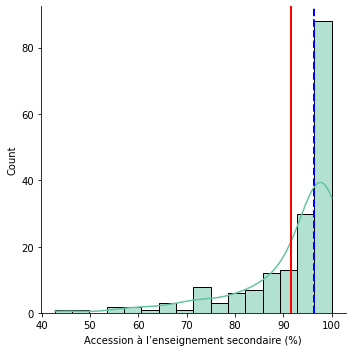

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.2871764705882353, pvalue=7.669420654110581e-13)

Adolescents non scolarisés (% des adolescents en âge de fréquenter le 1er cycle du secondaire)


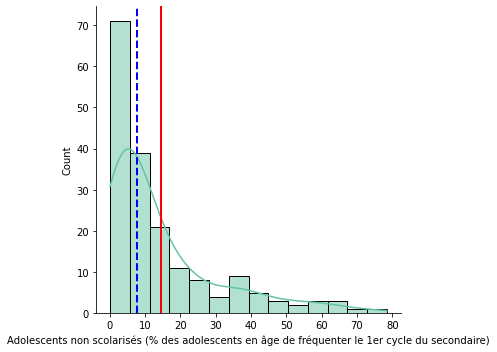

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.211, pvalue=4.2696206248304946e-07)

Enfants non scolarisés (% des enfants d’âge primaire)


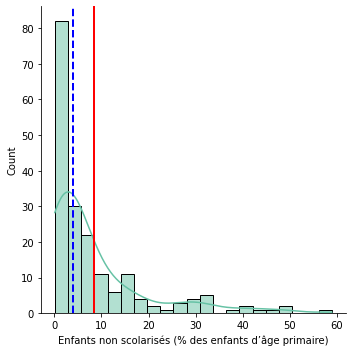

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.225, pvalue=5.1473696194292984e-08)

Inscriptions à l’école, enseignement supérieur (% brut)


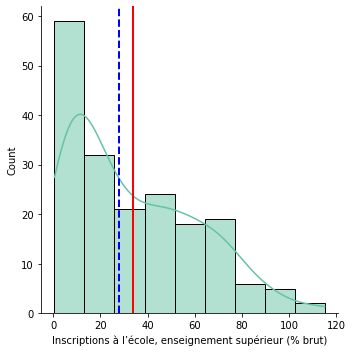

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.11509803921568627, pvalue=0.020454187379116973)

Inscriptions à l’école, primaire (% brut)


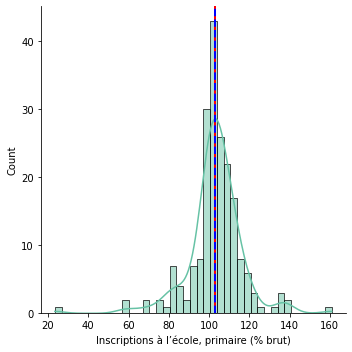

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.16992156862745098, pvalue=9.487649154915623e-05)

Inscriptions à l’école, préscolaire, (% brut)


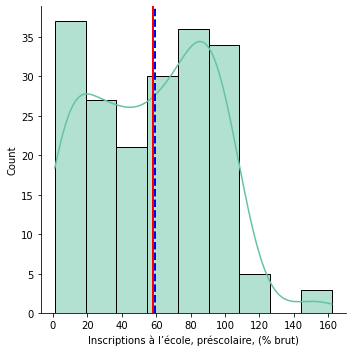

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.10833333333333334, pvalue=0.034374670376564276)

Inscriptions à l’école, secondaire (% brut)


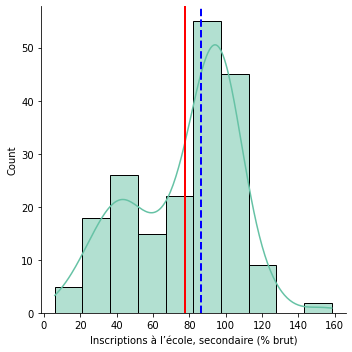

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.15374509803921568, pvalue=0.0005753747950787425)

Ratio femmes/hommes des inscriptions dans l’enseignement supérieur


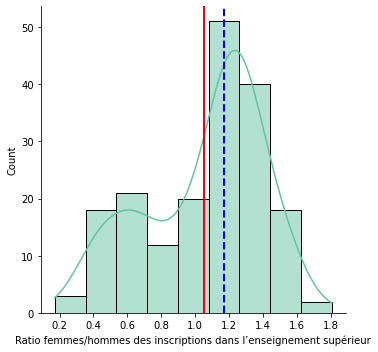

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.19801960784313727, pvalue=2.679673511751801e-06)

Ratio filles/garçons des inscriptions au primaire (%)


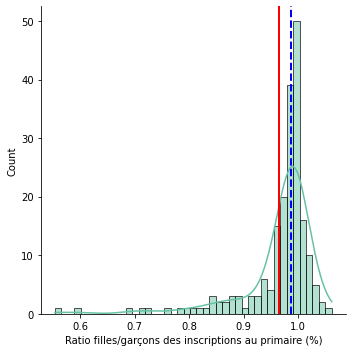

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.2681176470588235, pvalue=3.12988523987201e-11)

Ratio filles/garçons des inscriptions au secondaire (%)


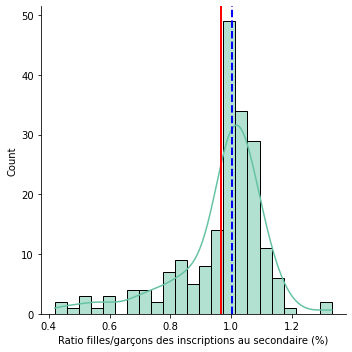

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.22309803921568627, pvalue=6.917921147042705e-08)

Taux d emploi, 15-24 ans (%) (estimation nationale)


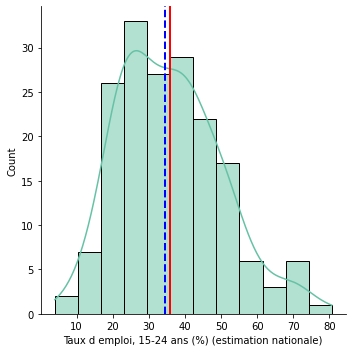

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.1478627450980392, pvalue=0.0010592474441586397)

Taux d’achèvement de l’école primaire, total (% du groupe d’âge pertinent)


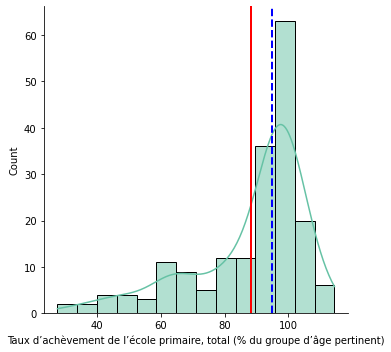

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.23176470588235293, pvalue=1.7620513159677387e-08)

Taux d’achèvement du premier cycle des études secondaires, total (% du groupe d’âge pertinent)


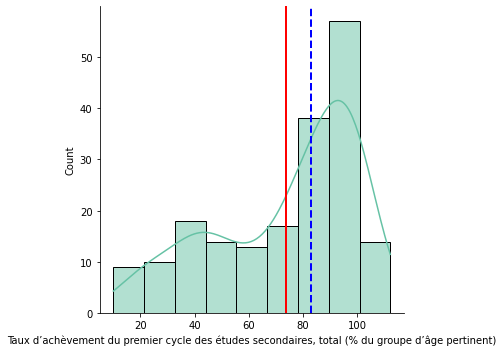

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.1936078431372549, pvalue=4.8670856787058625e-06)

Taux d’alphabétisation des jeunes (% des jeunes âgés de 15 à 24 ans)


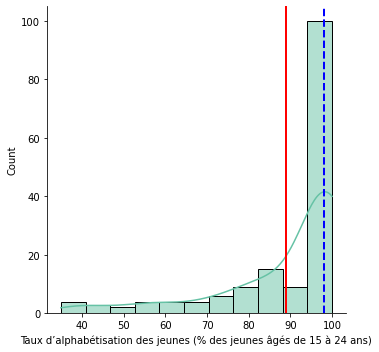

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.36405882352941177, pvalue=0.0)

Taux d’alphabétisation, total des adultes (% des personnes âgées de 15 ans et plus)


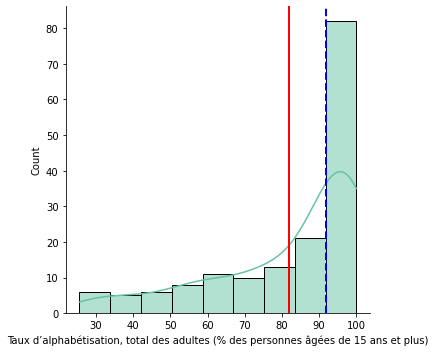

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.3120588235294118, pvalue=3.4416913763379853e-15)

Âge de début de l’école primaire (années)


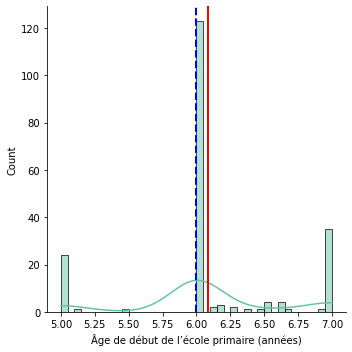

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.31354901960784315, pvalue=2.4424906541753444e-15)

Âge de début de l’école secondaire (années)


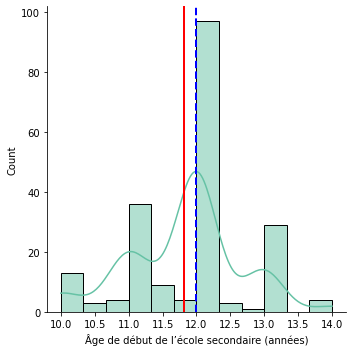

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.23476470588235293, pvalue=1.0836160413418838e-08)



In [12]:
for elt in cols:
    distrib_normalize(df_edu, elt)

L'analyse de la distribution (autant graphique que par le test de Kolmogorov-Smirnov) nous indique qu'aucune de nos variables ne suit la loi normale. Cependant, le nombre d'individus de notre échantillon étant grand (204), on considère que nos distributions tendent vers la loi normale (loi des grands nombres).

##### Statistiques descriptives des variables

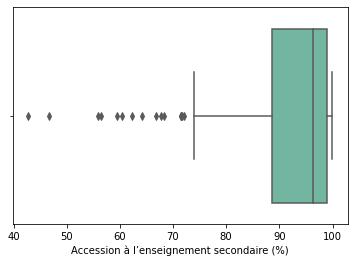

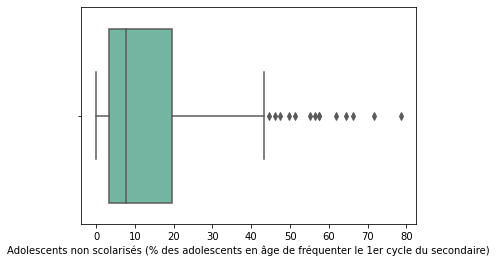

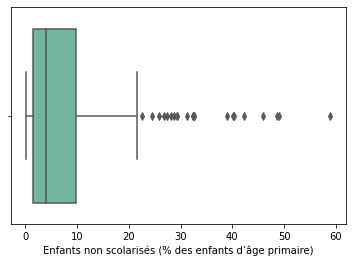

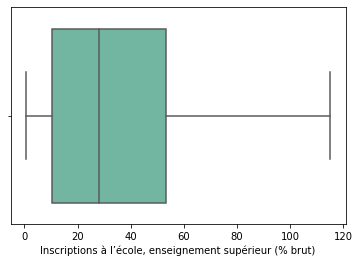

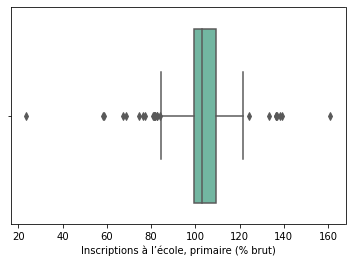

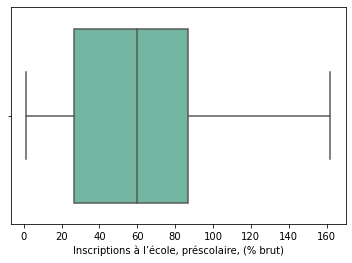

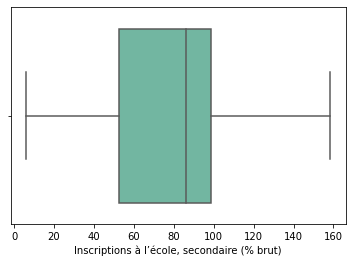

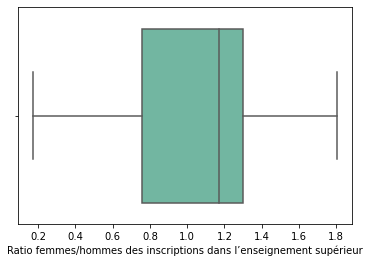

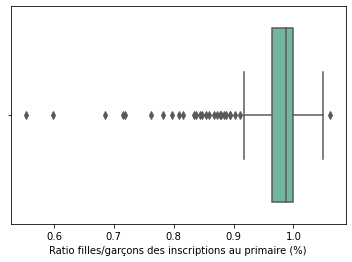

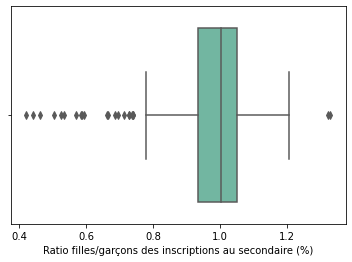

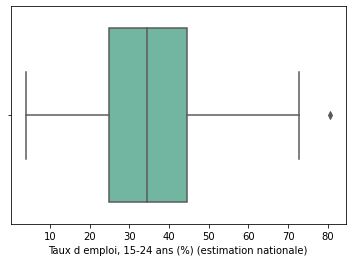

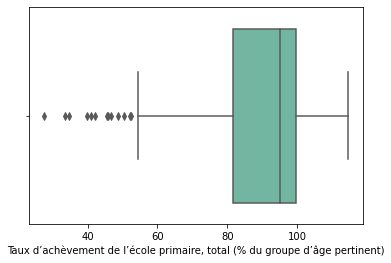

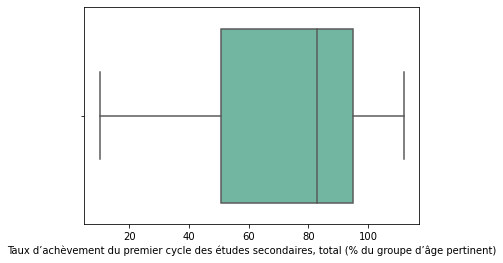

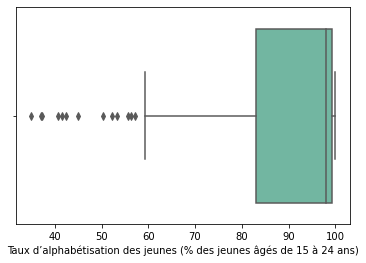

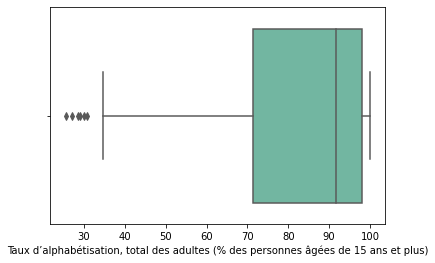

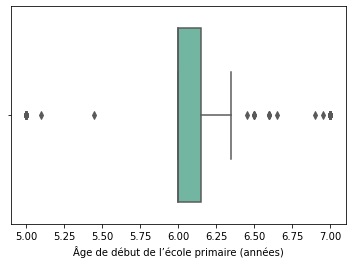

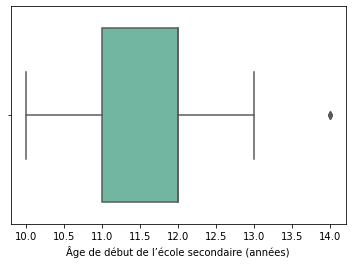

In [13]:
for elt in cols:
    sns.boxplot(x=elt, data=df_edu)
    plt.show()

In [14]:
# Calcul des médianes pour chaque variable
df_edu.median().T

Accession à l’enseignement secondaire (%)                                                          96.269669
Adolescents non scolarisés (% des adolescents en âge de fréquenter le 1er cycle du secondaire)      7.781353
Enfants non scolarisés (% des enfants d’âge primaire)                                               3.996940
Inscriptions à l’école, enseignement supérieur (% brut)                                            28.107104
Inscriptions à l’école, primaire (% brut)                                                         102.884563
Inscriptions à l’école, préscolaire, (% brut)                                                      59.574936
Inscriptions à l’école, secondaire (% brut)                                                        86.168283
Ratio femmes/hommes des inscriptions dans l’enseignement supérieur                                  1.171020
Ratio filles/garçons des inscriptions au primaire (%)                                               0.987594
Ratio filles/garçon

In [15]:
# Calcul des moyennes pour chaque variable
df_edu.mean().T

Accession à l’enseignement secondaire (%)                                                          91.608771
Adolescents non scolarisés (% des adolescents en âge de fréquenter le 1er cycle du secondaire)     14.438381
Enfants non scolarisés (% des enfants d’âge primaire)                                               8.487379
Inscriptions à l’école, enseignement supérieur (% brut)                                            34.041937
Inscriptions à l’école, primaire (% brut)                                                         103.124497
Inscriptions à l’école, préscolaire, (% brut)                                                      58.199774
Inscriptions à l’école, secondaire (% brut)                                                        77.581115
Ratio femmes/hommes des inscriptions dans l’enseignement supérieur                                  1.054695
Ratio filles/garçons des inscriptions au primaire (%)                                               0.965015
Ratio filles/garçon

### Anayses bivariées

Après l'analyse de nos variables une à une, on s'intéresse au corrélation entre nos variables. Pour cela, on va créer une matrice de corrélation. 

In [16]:
df_edu2 = df_edu.copy()
df_edu2.columns = ['pays', 'code_pays', 'acces_ens_second', 'ado_non-scol', 'enfants_non-scol', 
                   'inscriptions_ens_sup', 'inscriptions_primaire', 'inscriptions_préscol', 'inscriptions_secondaire', 
                   'ratio_ens_sup', 'ratio_primaire', 'ratio_secondaire', 'tx_emploi_15-24', 
                   'tx_achevement_primaire', 'tx_achevement_secondaire', 'tx_alphabetisation_jeunes', 
                   'tx_alphabetisation_total', 'age_debut_primaire', 'age_debut_secondaire']

#### Matrice de corrélation

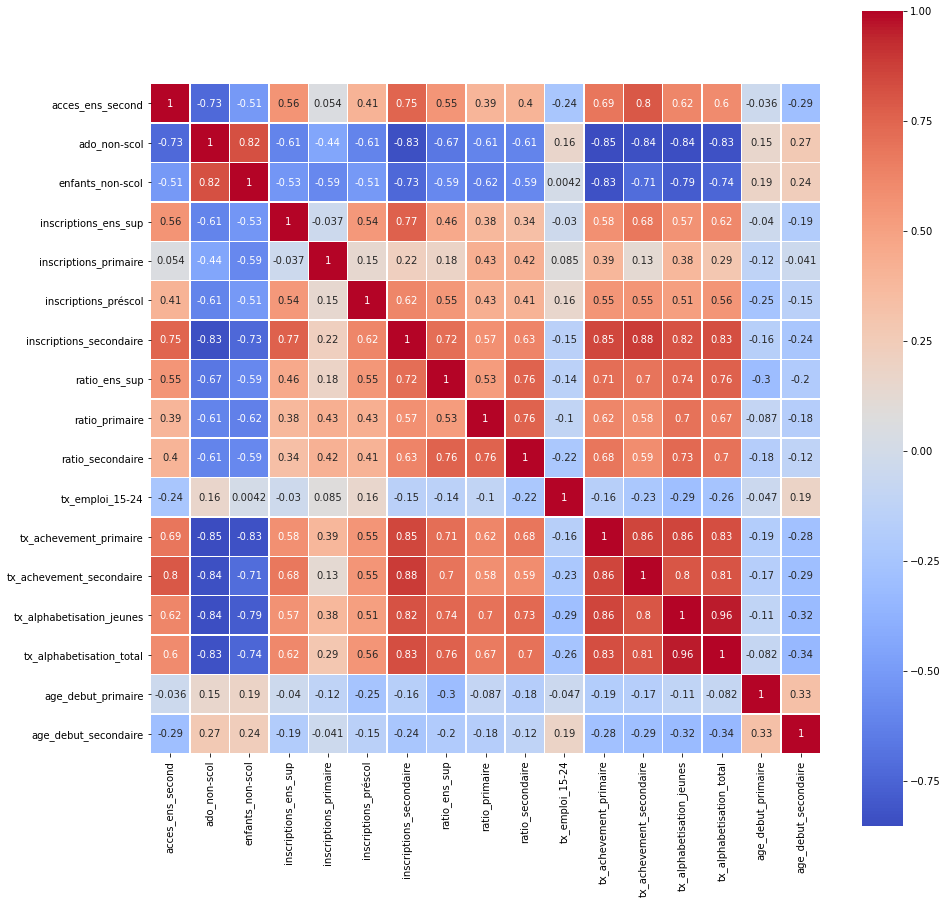

In [17]:
corrMatrix = df_edu2.corr()

plt.figure(figsize=(15,15))
sns.heatmap(corrMatrix, square=True, annot=True, linewidths=.5, cmap='coolwarm')
plt.show()

A l'aide de cette première matrice, on peut supprimer les variables qui ont aucune corrélation avec les autres. Cela concerne le taux d'emploi des 15 à 24 ans, l'âge de début du primaire et l'âge de début du secondaire. 

In [18]:
# On enlève les variables qui n'ont aucune corrélation avec les autres
df_edu2.drop(['tx_emploi_15-24', 'age_debut_primaire', 'age_debut_secondaire'], axis=1, inplace=True)

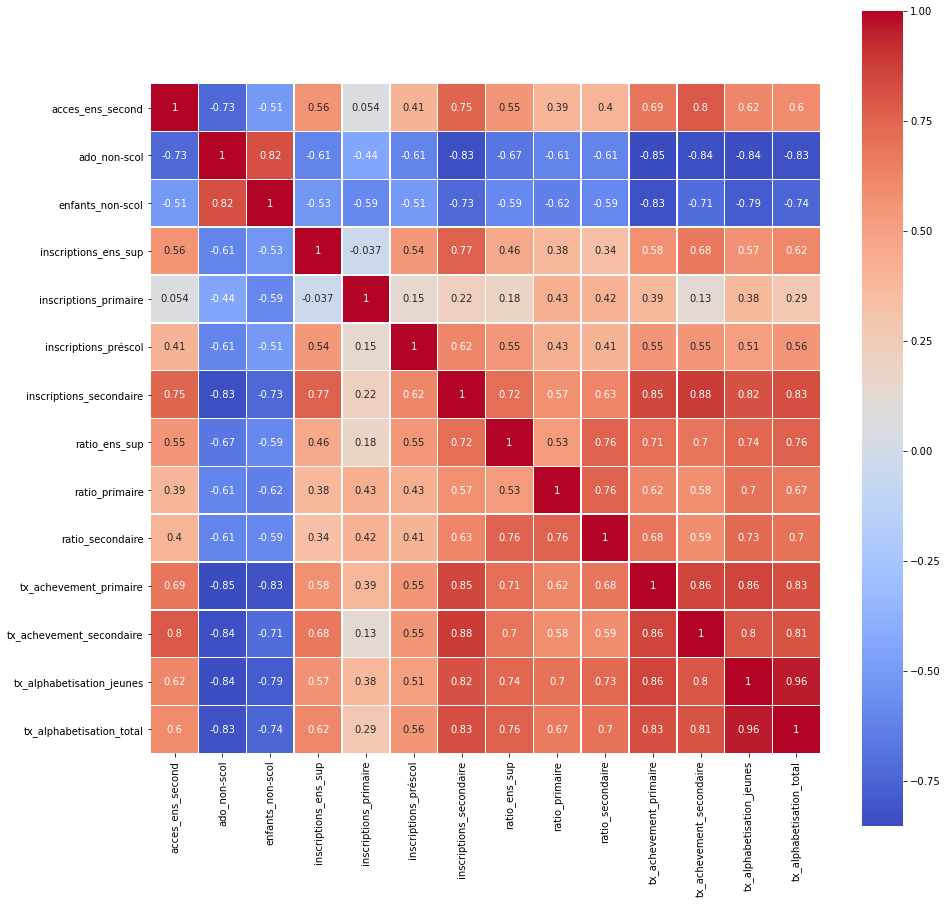

In [19]:
corrMatrix = df_edu2.corr()

plt.figure(figsize=(15,15))
sns.heatmap(corrMatrix, square=True, linewidths=.5, annot=True, cmap='coolwarm')
plt.show()

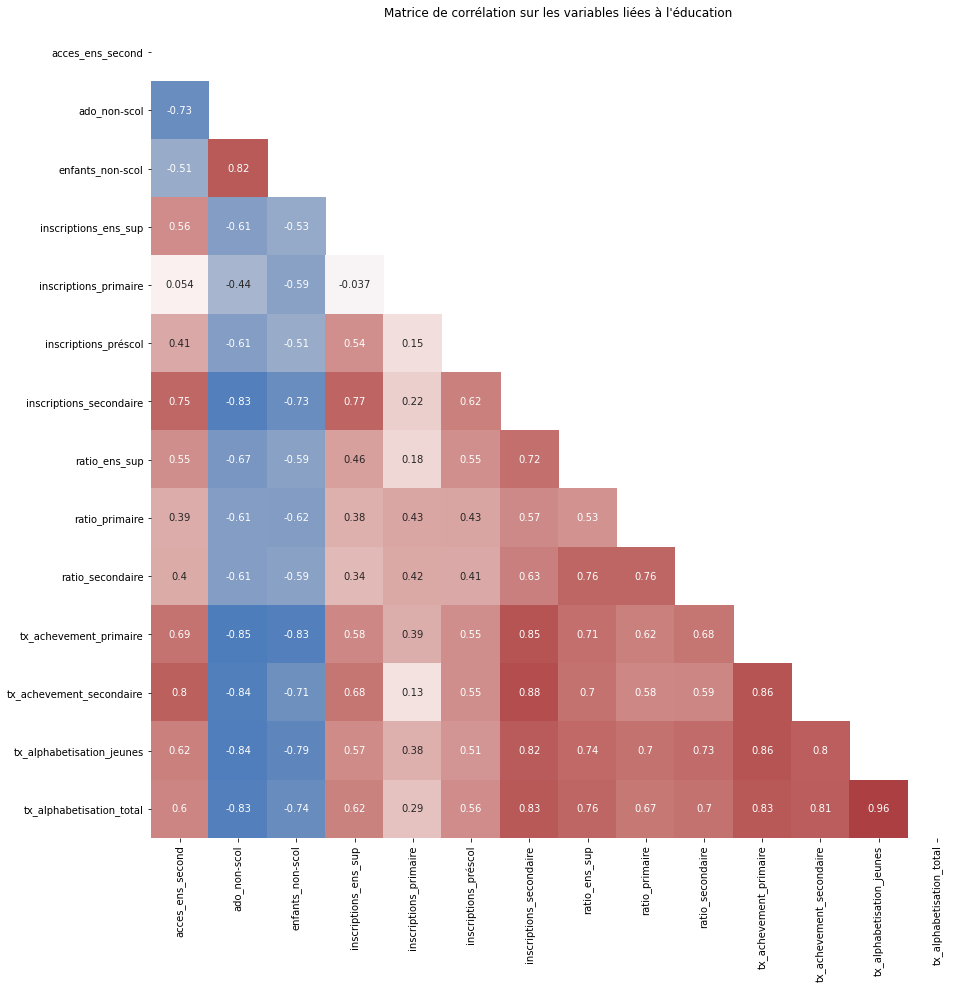

In [20]:
mask = np.triu(corrMatrix)

plt.figure(figsize=(15,15))
sns.heatmap(corrMatrix, square=True, mask = mask, fmt = '.2g', annot=True, vmin=-1, vmax=1, cmap='vlag', center= 0, cbar=False)
plt.title('Matrice de corrélation sur les variables liées à l\'éducation')
plt.savefig('Corr_matrix_education.png')
plt.show()

## Analyse en composantes principales

On effectue une analyse en composantes principales pour déterminer les features qui composent notre jeu de données, ainsi que les pays qui contribuent le plus à ces features.

In [21]:
# Préprocessing des data
# On n'a au préalable supprimer les variables qui n'avaient aucune corrélation avec les autres
data_acp = df_edu2.set_index('pays')
data_acp.drop('code_pays', axis=1, inplace = True)

print(data_acp.shape)
n = data_acp.shape[0]
p = data_acp.shape[1]

(204, 14)


In [22]:
# Remplacement des valeurs nulles par la médiane
data_acp[data_acp.columns] = data_acp[data_acp.columns].apply(pd.to_numeric, errors='coerce')
data_acp = data_acp.fillna(data_acp.median())

# Normalisation des valeurs
sc = StandardScaler()
Z = sc.fit_transform(data_acp)

In [23]:
acp = PCA()
print(acp)

PCA()


In [24]:
coord = acp.fit_transform(Z)
print(acp.n_components_)

14


In [25]:
# Correction de la variance expliquée
eigval = (n-1)/n*acp.explained_variance_
print(eigval)

[8.53804625 1.46161139 0.86336332 0.69983665 0.55638715 0.45895356
 0.38557099 0.29300882 0.19280213 0.16380208 0.14218961 0.12096894
 0.09100554 0.03245358]


In [26]:
# proportion de valeurs expliquées
ratio = acp.explained_variance_ratio_ * 100
print(acp.explained_variance_ratio_)

[0.60986045 0.10440081 0.06166881 0.04998833 0.03974194 0.0327824
 0.02754078 0.0209292  0.01377158 0.01170015 0.0101564  0.00864064
 0.0065004  0.00231811]


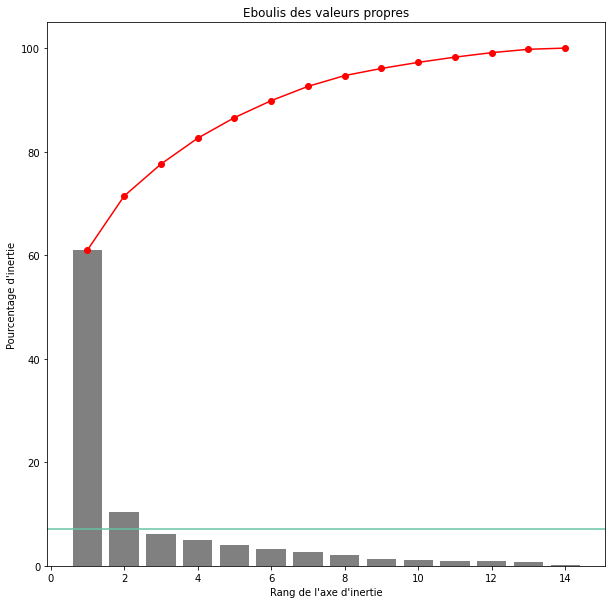

In [27]:
fig, ax = plt.subplots(figsize=(10,10))
scree = acp.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree, color='gray')
plt.plot(np.arange(len(scree))+1, scree.cumsum(),marker='o', color='r')
plt.axhline(y=100/p)
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

Selon le critère de Kaiser (100/p soit 100/14), le pourcentage d'inertie pour notre ACP doit être supérieur à 7,14%. On observe que la composante F1 explique à elle presque 61% et la composante F2 explique 10,4% de la variance. Notre analyse va donc se concentrer sur les composantes F1 et F2.

In [28]:
# contribution des individus dans l'inertie totale
di = np.sum(Z**2,axis=1)
print(pd.DataFrame({'ID':data_acp.index,'d_i':di}).sort_values('d_i', ascending=False))

                                ID         d_i
121                          Niger  112.066301
166                  Soudan du Sud  101.057636
174                          Tchad  100.871056
146      République centrafricaine   93.252130
164                        Somalie   88.680253
..                             ...         ...
80   Iran. République islamique d’    1.841409
22                         Bolivie    1.641500
95                           Liban    1.554470
199                     Îles Féroé    1.486113
55                     El Salvador    0.949133

[204 rows x 2 columns]


Le Niger, le Soudan du Sud, le Tchad, la République centrafricaine et la Somalie sont les cinq pays qui contribuent le plus à l'inertie totale de notre analyse en composante principale. 

In [29]:
# qualité de représentation des individus - COS2
cos2 = coord**2

for j in range(p):
  cos2[:,j] = cos2[:,j]/di

qualite = pd.DataFrame({'id':data_acp.index,'COS2_F1':cos2[:,0],'COS2_F2':cos2[:,1]})

print(qualite)

                            id   COS2_F1   COS2_F2
0                  Afghanistan  0.482953  0.078981
1               Afrique du Sud  0.152953  0.034683
2                      Albanie  0.787313  0.034278
3                      Algérie  0.104711  0.100189
4                    Allemagne  0.574556  0.095075
..                         ...       ...       ...
199                 Îles Féroé  0.776464  0.006127
200              Îles Marshall  0.033720  0.029494
201               Îles Salomon  0.114248  0.026393
202    Îles Turques-et-Caïques  0.000722  0.013312
203  Îles Vierges britanniques  0.650188  0.001035

[204 rows x 3 columns]


In [30]:
print(qualite.sort_values('COS2_F1', ascending=False).head(10))

                            id   COS2_F1   COS2_F2
146  République centrafricaine  0.942527  0.037810
51               Côte d'Ivoire  0.933444  0.032493
70                      Guinée  0.930674  0.032682
106                       Mali  0.920635  0.041610
174                      Tchad  0.918004  0.046411
28                Burkina Faso  0.912766  0.007639
197                   Éthiopie  0.906485  0.031116
121                      Niger  0.903628  0.041296
142                Royaume-Uni  0.888734  0.056539
39                      Chypre  0.870959  0.047282


La République centrafricaine, la Côté d'Ivoire, la Guinée, le Mali, le Tchad, le Burkina Faso, l'Ethiopie, le Niger, le Royaume-Uni et Chypre sont les dix nations qui contribuent à la qualité de la composante F1. 

In [31]:
print(qualite.sort_values('COS2_F2', ascending=False).head(10))

                       id   COS2_F1   COS2_F2
157  Sao Tomé-et-Principe  0.188105  0.635627
118               Namibie  0.000019  0.622162
143                Rwanda  0.304571  0.577829
164               Somalie  0.092179  0.526189
120             Nicaragua  0.013159  0.524913
93                Lesotho  0.062815  0.521973
63                  Gabon  0.022805  0.459235
125                 Népal  0.068467  0.435267
102            Madagascar  0.514976  0.387274
50                Curacao  0.158851  0.387202


Sao Tomé-et-Principe, la Namibie, le Rwanda, la Somalie, le Nicaragua, le Lesotho, le Gabon, le Népal, Madagascar et Curacao sont les dix nations qui contribuent à la qualité de représentation de la composante F2. 

In [32]:
# contribution aux axes
ctr = coord**2
for j in range(p):
  ctr[:,j] = ctr[:,j]/(n*eigval[j]) # eigval = c. 40 (variance expliquée et corrigé)

contribution = pd.DataFrame({'id':data_acp.index,'CTR_F1':ctr[:,0],'CTR_F2':ctr[:,1]})
print(contribution)

                            id    CTR_F1    CTR_F2
0                  Afghanistan  0.018259  0.017443
1               Afrique du Sud  0.000290  0.000384
2                      Albanie  0.001654  0.000421
3                      Algérie  0.000183  0.001025
4                    Allemagne  0.002345  0.002267
..                         ...       ...       ...
199                 Îles Féroé  0.000662  0.000031
200              Îles Marshall  0.000079  0.000405
201               Îles Salomon  0.000324  0.000438
202    Îles Turques-et-Caïques  0.000003  0.000364
203  Îles Vierges britanniques  0.002205  0.000020

[204 rows x 3 columns]


In [33]:
print(contribution.sort_values('CTR_F1', ascending=False).head(10))

                            id    CTR_F1    CTR_F2
121                      Niger  0.058140  0.015521
174                      Tchad  0.053165  0.015701
146  République centrafricaine  0.050462  0.011825
166              Soudan du Sud  0.041928  0.041804
70                      Guinée  0.039188  0.008039
28                Burkina Faso  0.036969  0.001807
106                       Mali  0.032683  0.008629
197                   Éthiopie  0.025604  0.005134
51               Côte d'Ivoire  0.021241  0.004319
110                 Mauritanie  0.019544  0.012018


Le Niger, le Tchad, la République centrafricaine, le Soudan du Sud, la Guinée, le Burkina Faso, le Mali, l'Ethiopie, la Côté d'Ivoire et la Mauritanie sont les 10 nations qui contribuent le plus à la première composante de notre analyse en composantes principales. 

In [34]:
print(contribution.sort_values('CTR_F2', ascending=False).head(10))

                            id    CTR_F1    CTR_F2
164                    Somalie  0.004693  0.156497
143                     Rwanda  0.003787  0.041975
166              Soudan du Sud  0.041928  0.041804
102                 Madagascar  0.007665  0.033671
104                     Malawi  0.003922  0.029645
127                    Ouganda  0.007678  0.028892
50                     Curacao  0.002017  0.028725
93                     Lesotho  0.000531  0.025767
132  Papouasie-Nouvelle-Guinée  0.004303  0.023878
173                   Tanzanie  0.014460  0.021979


La Somalie, le Rwanda, le Soudan du Sud, Madagascar, le Malawi, l'Ouganda, le Curacao, le Lesotho, la Papouasie-Nouvelle-Guinée et la Tanzanie sont les 10 pays qui contribuent le plus à la composante F2 de notre analyse en composantes principales. 

In [35]:
#racine carrée des valeurs propres
sqrt_eigval = np.sqrt(eigval)

#corrélation des variables avec les axes
corvar = np.zeros((p,p))
for k in range(p):
  corvar[:,k] = acp.components_[k,:] * sqrt_eigval[k]

#on affiche pour les deux premiers axes
print(pd.DataFrame({'id':data_acp.columns,'COR_1':corvar[:,0],'COR_2':corvar[:,1]}))

                           id     COR_1     COR_2
0            acces_ens_second -0.703031  0.372041
1                ado_non-scol  0.862401 -0.013182
2            enfants_non-scol  0.807996  0.184573
3        inscriptions_ens_sup -0.660756  0.443089
4       inscriptions_primaire -0.340682 -0.788744
5        inscriptions_préscol -0.644436  0.169389
6     inscriptions_secondaire -0.901148  0.148534
7               ratio_ens_sup -0.761603  0.073269
8              ratio_primaire -0.677467 -0.435194
9            ratio_secondaire -0.740712 -0.404221
10     tx_achevement_primaire -0.918139 -0.026034
11   tx_achevement_secondaire -0.899171  0.238744
12  tx_alphabetisation_jeunes -0.907284 -0.061120
13   tx_alphabetisation_total -0.897143  0.013664


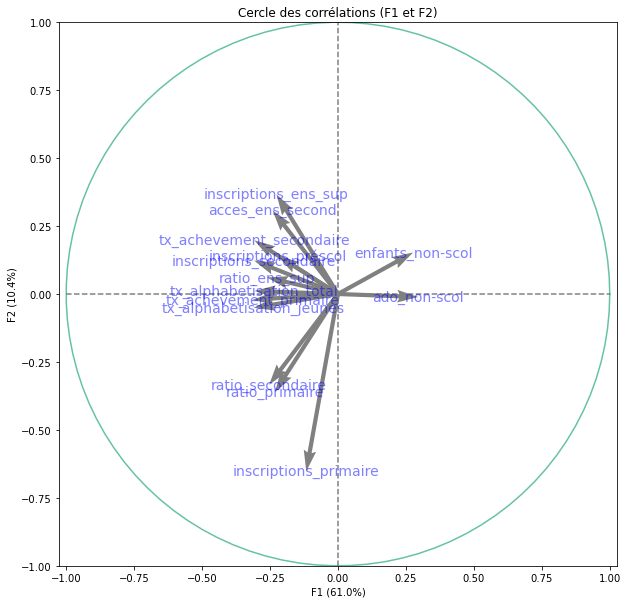

In [36]:
pcs = acp.components_
features = data_acp.columns
display_circles(pcs, p, acp, [(0,1)], labels = np.array(features))

In [37]:
#cosinus carré des variables
cos2var = corvar**2
#print(pd.DataFrame({'id':data_acp.columns,'COS2_1':cos2var[:,0],'COS2_2':cos2var[:,1]}))

In [38]:
#contributions
ctrvar = cos2var
for k in range(p):
  ctrvar[:,k] = ctrvar[:,k]/eigval[k]

#on n'affiche que pour les deux premiers axes
print(pd.DataFrame({'id':data_acp.columns,'CTR_1':ctrvar[:,0],'CTR_2':ctrvar[:,1]}))

                           id     CTR_1     CTR_2
0            acces_ens_second  0.057888  0.094700
1                ado_non-scol  0.087108  0.000119
2            enfants_non-scol  0.076465  0.023308
3        inscriptions_ens_sup  0.051136  0.134323
4       inscriptions_primaire  0.013594  0.425637
5        inscriptions_préscol  0.048641  0.019631
6     inscriptions_secondaire  0.095112  0.015095
7               ratio_ens_sup  0.067936  0.003673
8              ratio_primaire  0.053755  0.129579
9            ratio_secondaire  0.064260  0.111791
10     tx_achevement_primaire  0.098732  0.000464
11   tx_achevement_secondaire  0.094695  0.038997
12  tx_alphabetisation_jeunes  0.096411  0.002556
13   tx_alphabetisation_total  0.094268  0.000128


F1 : Adolescents non scolarisés, Enfants non scolarisés, Inscriptions en préscolaire, Ratio femmes/hommes des inscriptions dans l’enseignement supérieur, Inscriptions à l’école secondaire, Taux d'achèvement au primaire, Taux d'achèvement en secondaire, Taux d'alphabétisation des jeunes et de la population adulte

F2 : Accession à l'enseignement secondaire, Inscriptions en cycle supérieur, Inscriptions à l’école primaire, Ratio filles/garçons des inscriptions au primaire, Ratio filles/garçons des inscriptions au secondaire

## Conclusion

L'état des lieux de l'accès à l'éducation est quelque chose de complexe qui nécessite de prendre en compte le nombre d'inscriptions dans les différents cycles scolaires, les taux d'achèvement mais aussi les ratio filles/garçons ainsi que le taux d'alphabétisation. On remarque que les pays où le taux d'alphabétisation est faible ont aussi de faibles pourcentages d'inscription dans les différents et de faibles ratio femmes/hommes.

In [39]:
df_edu2.columns = ['pays','code_pays', 
                   'acces_ens_secondaire', 'ados_non-scol', 
                   'enfants_non-scol', 'inscriptions_ens_sup', 
                   'inscriptions_primaire', 'inscriptions_préscol', 
                   'inscriptions_secondaire', 'ratio_ens_sup', 
                   'ratio_primaire', 'ratio_secondaire', 
                   'tx_achevement_primaire', 'tx_achevement_secondaire', 
                   'tx_alphabétisation_jeunes', 'tx_alphabétisation_total']

cols_num = ['acces_ens_secondaire', 'ados_non-scol', 
            'enfants_non-scol', 'inscriptions_ens_sup', 
            'inscriptions_primaire', 'inscriptions_préscol', 
            'inscriptions_secondaire', 'ratio_ens_sup', 
            'ratio_primaire', 'ratio_secondaire', 
            'tx_achevement_primaire', 'tx_achevement_secondaire', 
            'tx_alphabétisation_jeunes', 'tx_alphabétisation_total']

# Remplacement des valeurs nulles par la médiane
df_edu2[cols_num] = df_edu2[cols_num].fillna(df_edu2[cols_num].median())

df_edu2.to_csv('df_edu_clean.csv')
df_edu2.to_excel('df_edu_clean.xlsx')

In [40]:
df_edu2.head()

,pays,code_pays,acces_ens_secondaire,ados_non-scol,enfants_non-scol,inscriptions_ens_sup,inscriptions_primaire,inscriptions_préscol,inscriptions_secondaire,ratio_ens_sup,ratio_primaire,ratio_secondaire,tx_achevement_primaire,tx_achevement_secondaire,tx_alphabétisation_jeunes,tx_alphabétisation_total
0,Afghanistan,AFG,89.783073,7.781353,3.996940,4.619342,94.895554,3.080470,39.700971,0.294833,0.599088,0.442298,83.511772,43.786143,56.205299,37.234284
1,Afrique du Sud,ZAF,96.816158,13.785806,7.176252,20.994972,104.268580,22.914647,94.457259,1.296527,0.963646,1.068906,90.047670,80.105780,98.176697,92.109441
2,Albanie,ALB,98.833753,4.755447,6.472873,41.650427,100.335247,66.300319,86.715374,1.308677,1.016700,0.982993,96.282486,92.401003,99.123790,97.377008
3,Algérie,DZA,96.591529,7.781353,2.718592,29.798487,111.345440,35.694609,80.699898,1.299649,0.938633,1.063733,98.099923,71.474606,93.277674,74.766516
4,Allemagne,DEU,99.627867,2.639915,2.280481,67.467917,102.896194,108.693307,101.335926,0.985777,0.995832,0.959991,100.295240,82.629459,98.002903,91.785003


Pour comprendre cette situation, il peut être intéressant de se pencher sur la situation économique de nos 204 pays. 

# Etat des lieux de la situation économique

In [41]:
# Chargement des données
df_eco = pd.read_csv('data_eco.csv', sep=';', encoding='utf-8')

df_eco.drop('Unnamed: 0', axis=1, inplace=True)
df_eco = df_eco.apply(lambda x: x.str.replace(',','.'))

cols = df_eco.columns.to_list()
cols.pop(0)
cols.pop(0)

for i in cols:
    df_eco[i] = df_eco[i].astype('float')

df_eco.head()

,Pays,Code ISO,Capacité (+)/besoin (-) de financement (% du PIB),Chômage (% de la population active) (estimation nationale),Croissance du PIB (% annuel),Croissance du PIB par habitant (% annuel),Croissance du RNB (% annuel),Croissance du RNB par habitant (% annuel),Créances sur le gouvernement central (% du PIB),Dépenses (% du PIB),...,Population âgée de 0 à 14 ans (% du total),RNB ($ US courants),"Taux d emploi, 15 ans et plus (%) (estimation nationale)",Taux d’activité des 15-24 ans (%) (estimation nationale),Total de dette extérieure (% du RNB),Total des réserves (% de la dette extérieure totale),Valeur actuelle de la dette extérieure (% du RNB),Épargne brute (% du PIB),Épargne brute (% du RNB),Épargne intérieure brute (% du PIB)
0,Afghanistan,AFG,-0.461142,5.817500,6.664775,3.452640,NaN,NaN,-6.868596,41.615336,...,46.730536,1.843331e+10,49.372499,45.339999,0.198377,258.877744,2.479109,NaN,NaN,NaN
1,Afrique du Sud,ZAF,-3.156518,27.014737,2.558669,1.144181,2.514491,1.100648,22.192152,31.469927,...,30.210918,2.891640e+11,38.091579,27.254737,3.422221,36.339358,5.570765,16.371788,16.807039,19.719900
2,Albanie,ALB,-3.236472,14.582632,4.117023,4.555113,2.668352,2.954737,31.548796,23.664798,...,22.720388,1.078690e+10,47.963571,34.666428,3.415912,51.868798,8.258809,21.311708,21.014951,9.391536
3,Algérie,DZA,NaN,14.311176,3.252632,1.493450,3.323473,1.563445,-9.840237,NaN,...,29.146231,1.425052e+11,34.886250,25.401429,2.775051,1846.814195,0.283073,47.290134,48.225100,45.964392
4,Allemagne,DEU,-0.606787,6.815263,1.266693,1.210430,1.490509,1.446956,3.221730,29.304015,...,13.942774,3.335235e+12,55.450000,50.402631,NaN,NaN,NaN,26.247102,25.842292,26.142249


In [42]:
df_eco.shape

(217, 30)

In [43]:
df_eco.isnull().mean()

Pays                                                                                    0.000000
Code ISO                                                                                0.000000
Capacité (+)/besoin (-) de financement (% du PIB)                                       0.327189
Chômage (% de la population active) (estimation nationale)                              0.059908
Croissance du PIB (% annuel)                                                            0.036866
Croissance du PIB par habitant (% annuel)                                               0.036866
Croissance du RNB (% annuel)                                                            0.235023
Croissance du RNB par habitant (% annuel)                                               0.235023
Créances sur le gouvernement central (% du PIB)                                         0.147465
Dépenses (% du PIB)                                                                     0.317972
Dépenses publiques en éducatio

## Analyses descriptives

In [44]:
cols = df_eco.columns.to_list()
cols.pop(0)
cols.pop(0)

print(cols)

['Capacité (+)/besoin (-) de financement (% du PIB)', 'Chômage (%\xa0de la population active) (estimation nationale)', 'Croissance du PIB (%\xa0annuel)', 'Croissance du PIB par habitant (%\xa0annuel)', 'Croissance du RNB (% annuel)', 'Croissance du RNB par habitant (% annuel)', 'Créances sur le gouvernement central (% du PIB)', 'Dépenses (%\xa0du PIB)', 'Dépenses publiques en éducation (%\xa0du PIB)', 'Dépenses publiques en éducation, total (%\xa0des dépenses du gouvernement)', 'Indice GINI', 'Inflation, déflateur du PIB (%\xa0annuel)', 'Masse monétaire (% du PIB)', 'PIB ($\xa0US courants)', 'PIB par habitant ($\xa0US courants)', 'Part des revenus détenus par les 20%\xa0moins élevés', 'Part des revenus détenus par les 20%\xa0plus élevés', 'Population active avec un niveau d’études de base (%\xa0de la population active totale)', 'Population âgée de 0 à 14 ans (%\xa0du total)', 'RNB ($\xa0US courants)', 'Taux d emploi, 15\xa0ans et plus (%) (estimation nationale)', 'Taux d’activité des 1

### Analyses univariées

#### Distribution des variables

Capacité (+)/besoin (-) de financement (% du pib)


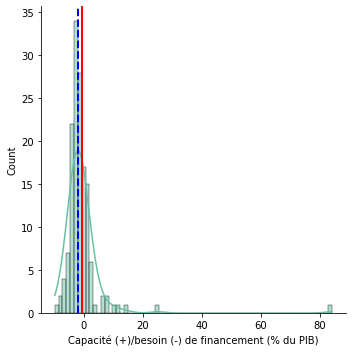

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.33540552995391704, pvalue=5.551115123125783e-16)

Chômage (% de la population active) (estimation nationale)


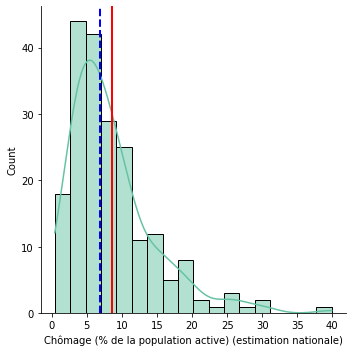

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.10563594470046082, pvalue=0.03435349601289106)

Croissance du pib (% annuel)


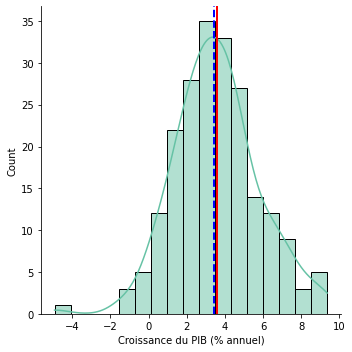

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.06607373271889401, pvalue=0.397627021555673)

Croissance du pib par habitant (% annuel)


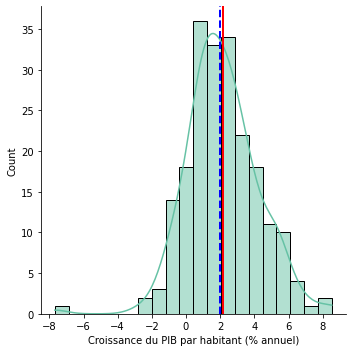

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.05868202764976958, pvalue=0.5479303386302451)

Croissance du rnb (% annuel)


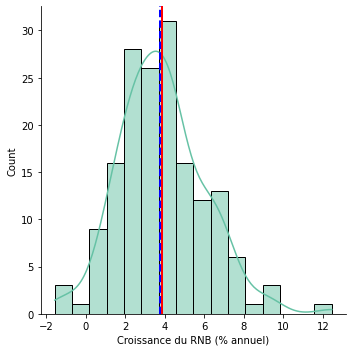

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.2464562211981567, pvalue=5.151502557865228e-10)

Croissance du rnb par habitant (% annuel)


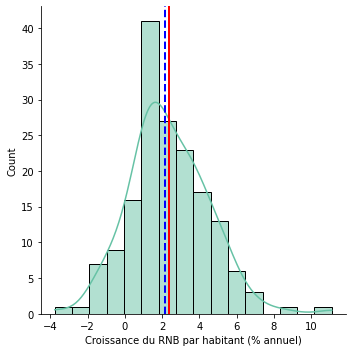

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.24406451612903227, pvalue=7.916254318729443e-10)

Créances sur le gouvernement central (% du pib)


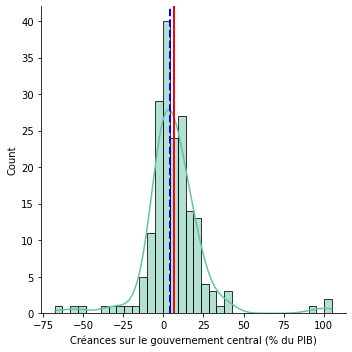

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.17940092165898616, pvalue=1.7036381376622778e-05)

Dépenses (% du pib)


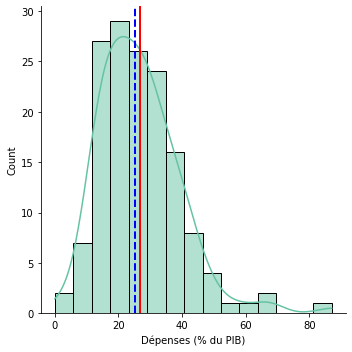

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.33440552995391704, pvalue=5.551115123125783e-16)

Dépenses publiques en éducation (% du pib)


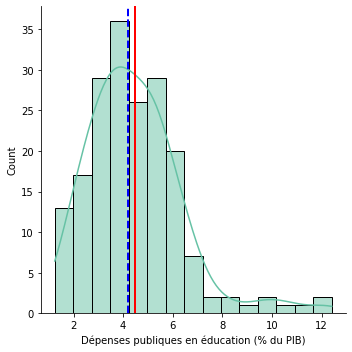

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.16089861751152074, pvalue=0.00016704791398547414)

Dépenses publiques en éducation, total (% des dépenses du gouvernement)


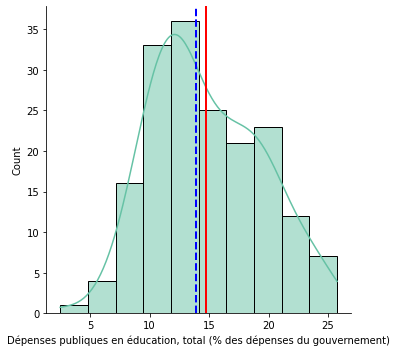

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.2026635944700461, pvalue=6.749695803387468e-07)

Indice gini


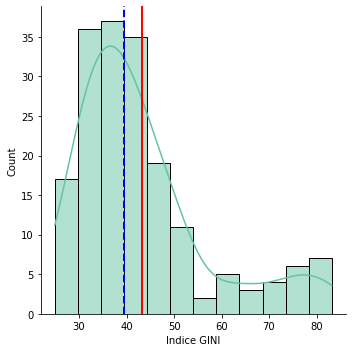

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.2194147465437788, pvalue=5.1456870542310185e-08)

Inflation, déflateur du pib (% annuel)


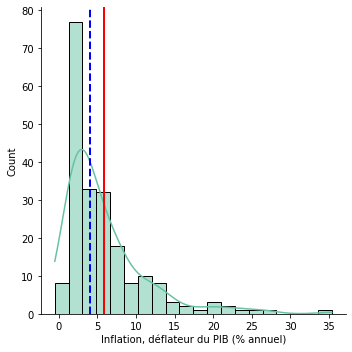

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.1695668202764977, pvalue=5.9101660513816157e-05)

Masse monétaire (% du pib)


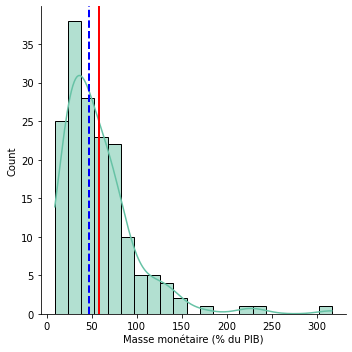

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.2504562211981567, pvalue=2.4866719794403025e-10)

Pib ($ us courants)


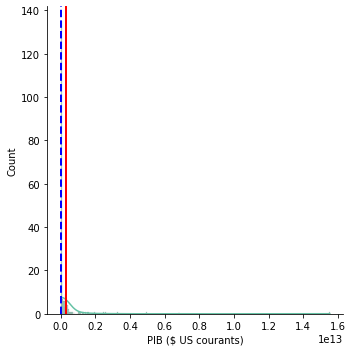

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.39, pvalue=5.551115123125783e-16)

Pib par habitant ($ us courants)


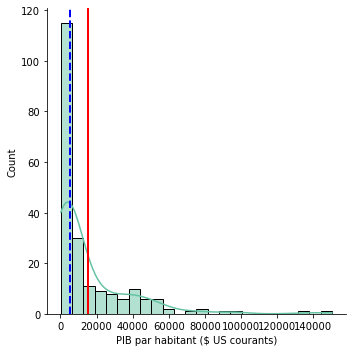

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.252, pvalue=1.8646617583328862e-10)

Part des revenus détenus par les 20% moins élevés


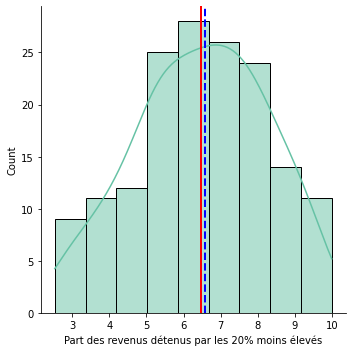

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.2626728110599078, pvalue=2.49172904531747e-11)

Part des revenus détenus par les 20% plus élevés


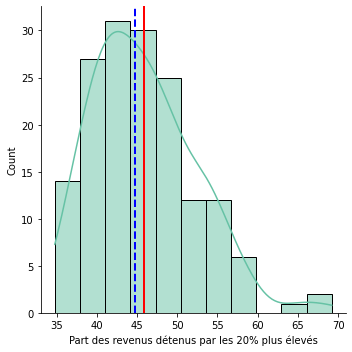

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.27653917050691246, pvalue=1.5913936834976994e-12)

Population active avec un niveau d’études de base (% de la population active totale)


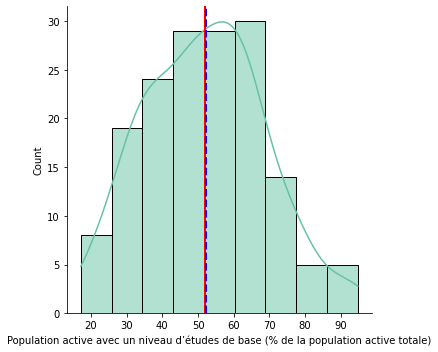

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.26388940092165897, pvalue=1.9688251029492676e-11)

Population âgée de 0 à 14 ans (% du total)


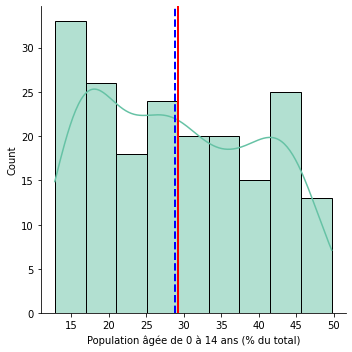

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.16653917050691244, pvalue=8.556304802043169e-05)

Rnb ($ us courants)


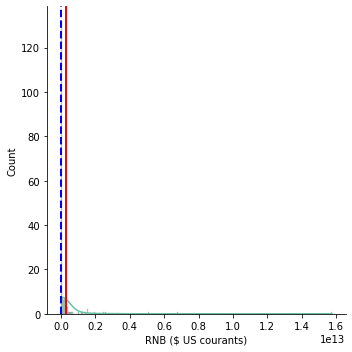

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.375, pvalue=5.551115123125783e-16)

Taux d emploi, 15 ans et plus (%) (estimation nationale)


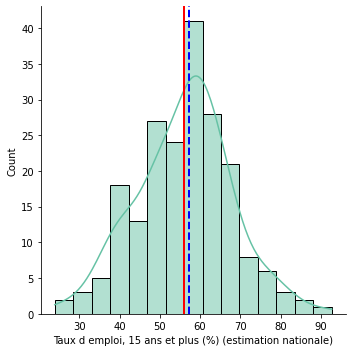

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.08259907834101382, pvalue=0.16456011589905573)

Taux d’activité des 15-24 ans (%) (estimation nationale)


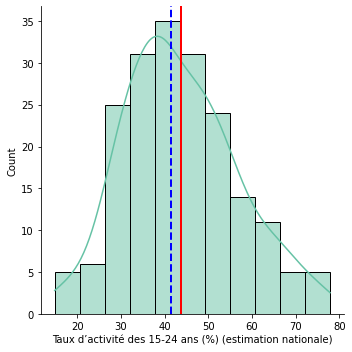

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.14815668202764978, pvalue=0.0006948415159767629)

Total de dette extérieure (% du rnb)


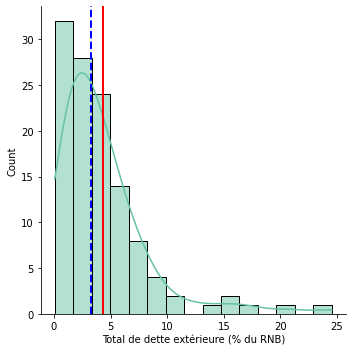

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.47126267281105994, pvalue=5.551115123125783e-16)

Total des réserves (% de la dette extérieure totale)


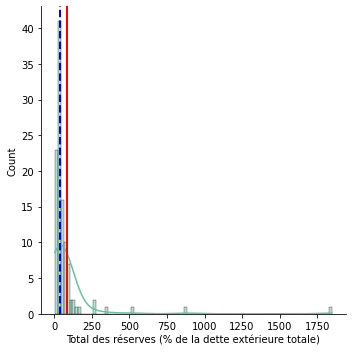

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.5069124423963134, pvalue=5.551115123125783e-16)

Valeur actuelle de la dette extérieure (% du rnb)


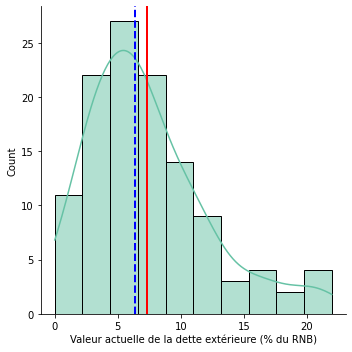

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.4722626728110599, pvalue=5.551115123125783e-16)

Épargne brute (% du pib)


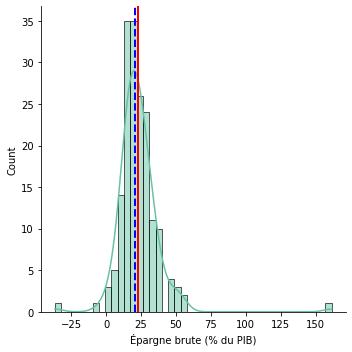

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.19815668202764977, pvalue=1.3032239097876541e-06)

Épargne brute (% du rnb)


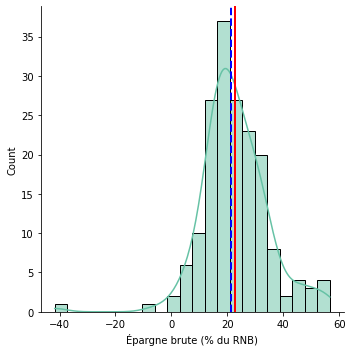

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.21702304147465437, pvalue=7.528786805099941e-08)

Épargne intérieure brute (% du pib)


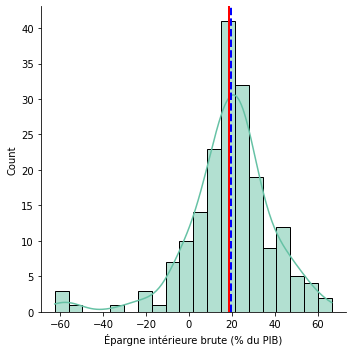

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.1518110599078341, pvalue=0.00046759808691909654)



In [45]:
for elt in cols:
    distrib_normalize(df_eco, elt)

Trois de nos variables suivent la loi normale, il s'agit de la croissance du PIB, de la croissance du PIB par habitant et du taux d'emploi des 15 ans et plus. Pour les autres variables, l'analyse des graphiques ainsi que des tests de Kolmogorov-Smirnoff ne permettent pas de dire que nos distributions suivent la loi normale. En revanche notre échantillon étant composée de 217 pays, on peut considérer que nos variables suivent la loi normale.  

#### Statistiques descriptives des variables

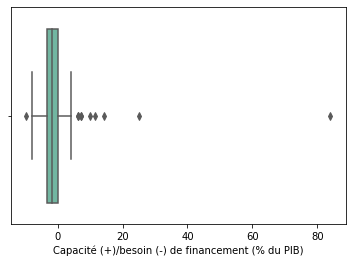

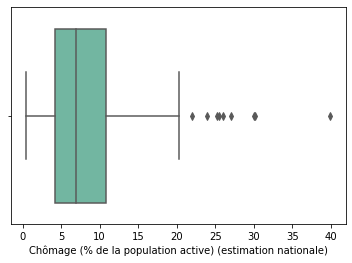

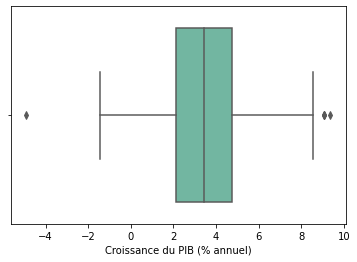

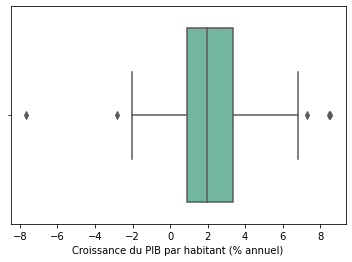

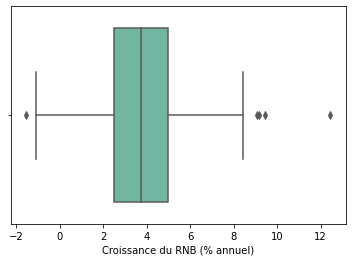

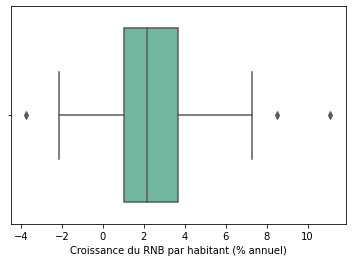

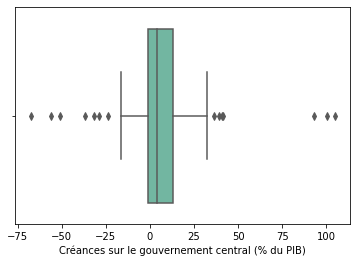

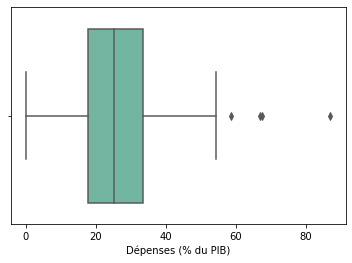

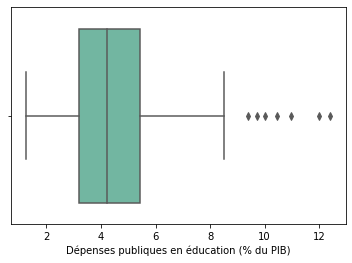

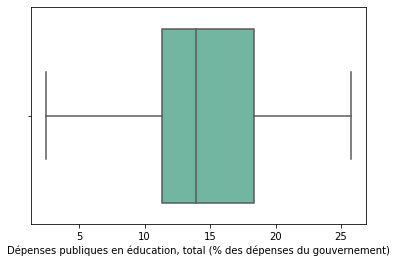

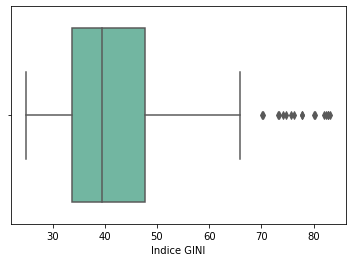

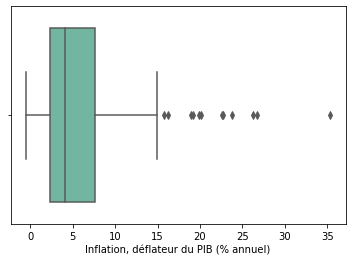

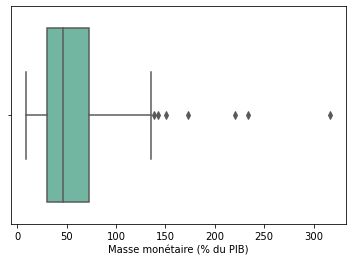

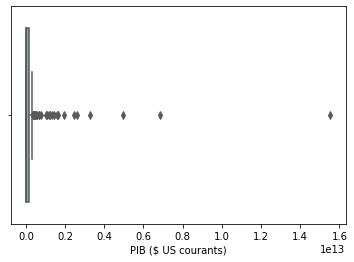

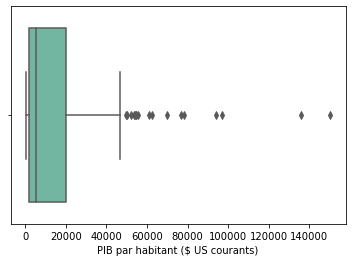

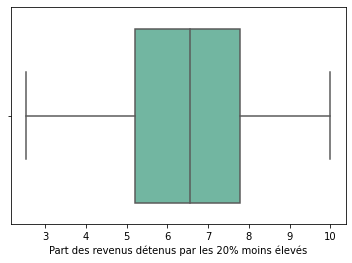

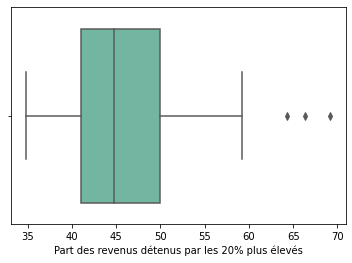

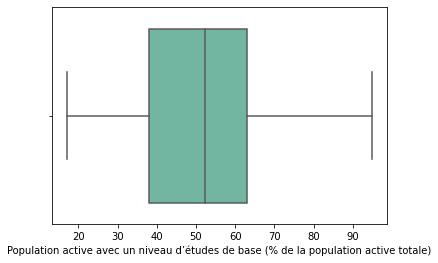

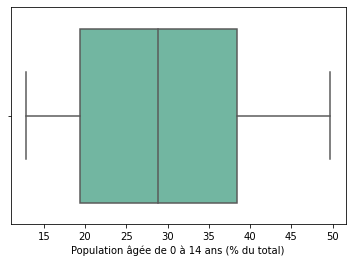

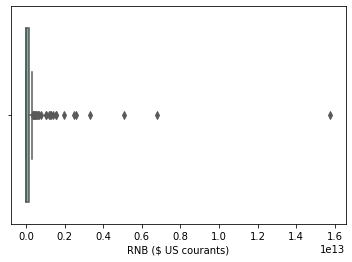

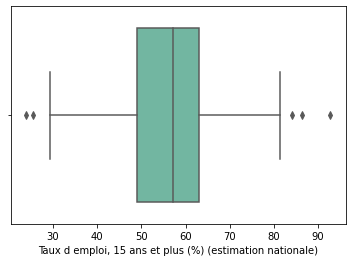

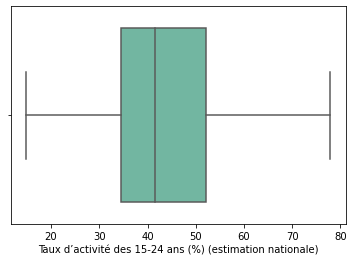

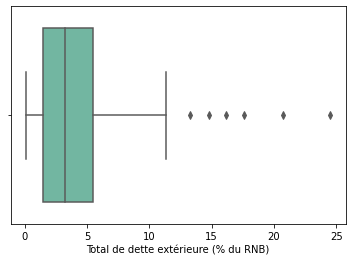

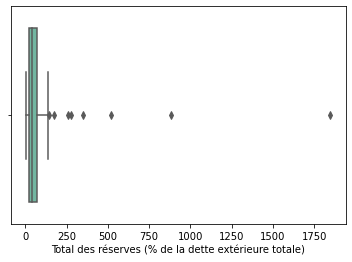

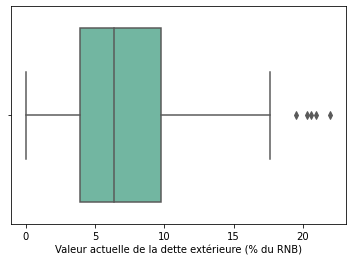

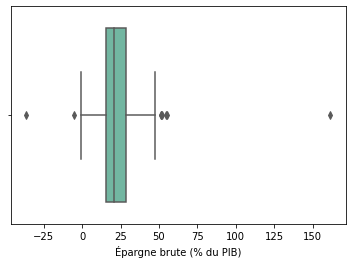

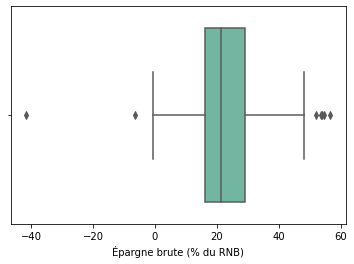

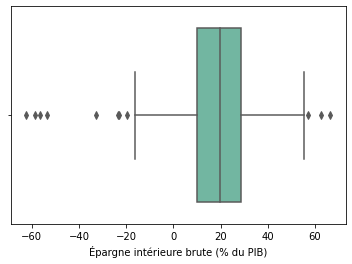

In [46]:
for elt in cols:
    sns.boxplot(x=elt, data=df_eco)
    plt.show()

In [47]:
df_eco.mean().T

Capacité (+)/besoin (-) de financement (% du PIB)                                      -5.647118e-01
Chômage (% de la population active) (estimation nationale)                              8.589983e+00
Croissance du PIB (% annuel)                                                            3.575818e+00
Croissance du PIB par habitant (% annuel)                                               2.137154e+00
Croissance du RNB (% annuel)                                                            3.856968e+00
Croissance du RNB par habitant (% annuel)                                               2.363818e+00
Créances sur le gouvernement central (% du PIB)                                         6.354388e+00
Dépenses (% du PIB)                                                                     2.666204e+01
Dépenses publiques en éducation (% du PIB)                                              4.482390e+00
Dépenses publiques en éducation, total (% des dépenses du gouvernement)                 1.4

In [48]:
df_eco.median().T

Capacité (+)/besoin (-) de financement (% du PIB)                                      -1.840846e+00
Chômage (% de la population active) (estimation nationale)                              6.880263e+00
Croissance du PIB (% annuel)                                                            3.454174e+00
Croissance du PIB par habitant (% annuel)                                               1.983123e+00
Croissance du RNB (% annuel)                                                            3.740233e+00
Croissance du RNB par habitant (% annuel)                                               2.168450e+00
Créances sur le gouvernement central (% du PIB)                                         3.968033e+00
Dépenses (% du PIB)                                                                     2.520033e+01
Dépenses publiques en éducation (% du PIB)                                              4.212266e+00
Dépenses publiques en éducation, total (% des dépenses du gouvernement)                 1.3

In [49]:
df_eco.to_csv('df_eco.csv')
df_eco.to_excel('df_eco.xlsx')

In [50]:
df_eco2 = df_eco.copy()
df_eco2.columns = ['pays', 'code_pays', 'cap_financement', 
                   'chômage total', 'croissance_PIB', 'croissance_PIB_hab', 
                   'croissance_RNB', 'croissance_RNB_hab', 'creances_gouv_central', 
                   'depenses', 'depenses_pub_educ', 'depenses_pub_educ_total', 'Indice GINI', 
                   'inflateur', 'masse_monetaire', 'PIB', 'PIB_hab', 'part_revenus_20prc_moins', 'part_revenus_20prc_plus', 
                   'pop_active_avc_niveau_diplom', 'pop_0-14', 'RNB', 'tx_emploi_15+', 
                   'tx_emploi_15-24', 'tot_dette_exterieur', 'tot_reserves', 'val_dette_exterieur', 
                   'epargne_brut_PIB', 'epargne_brut_RNB', 'epargne_interieure_brut']

### Analyses bivariées

#### Matrice de corrélation

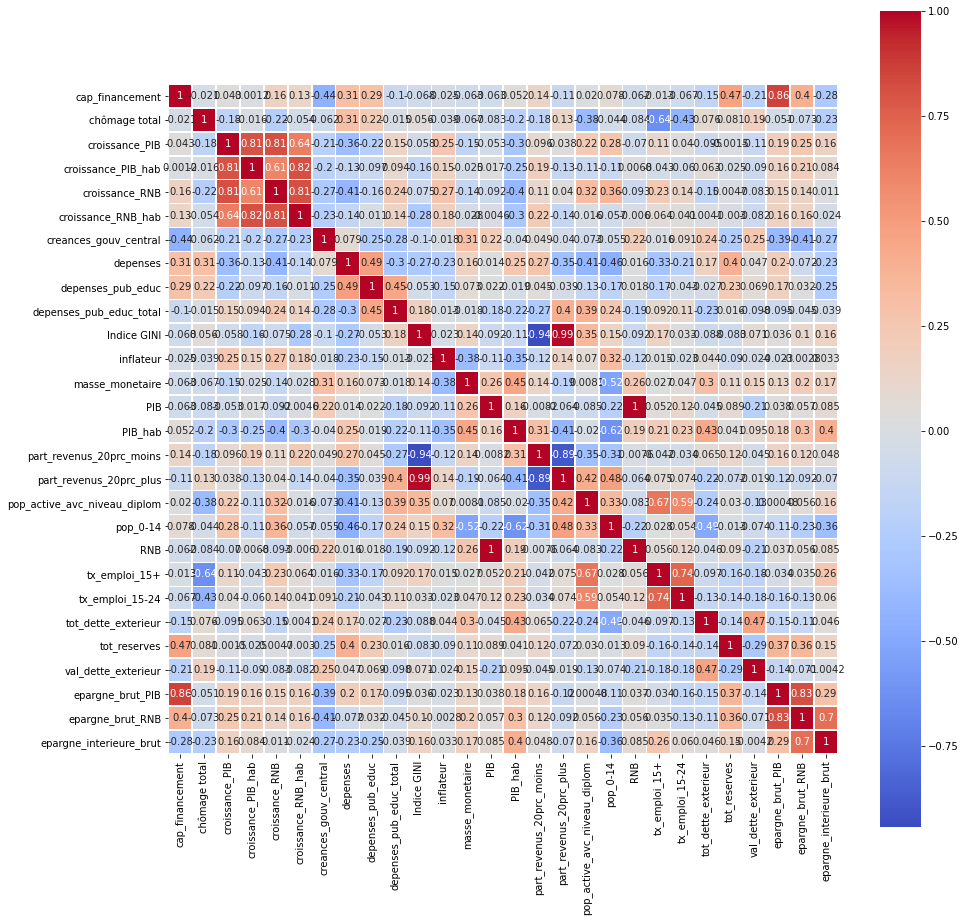

In [51]:
corrMatrix = df_eco2.corr()

plt.figure(figsize=(15,15))
sns.heatmap(corrMatrix, square=True, annot=True, linewidths=.5, cmap='coolwarm')
plt.show()

In [52]:
# On enlève les variables qui n'ont aucune corrélation avec les autres
# De plus, le RNB et le PIB étant fortement corrélée (1), on supprime le RNB pour éviter la redondance dans nos variables
df_eco2.drop(['croissance_RNB', 'croissance_RNB_hab', 'creances_gouv_central', 'depenses', 'depenses_pub_educ', 'depenses_pub_educ_total', 'inflateur', 
              'masse_monetaire', 'PIB', 'PIB_hab', 'pop_0-14', 'RNB', 'tot_dette_exterieur', 'tot_reserves', 'val_dette_exterieur', 'epargne_brut_RNB'], axis=1, inplace=True)

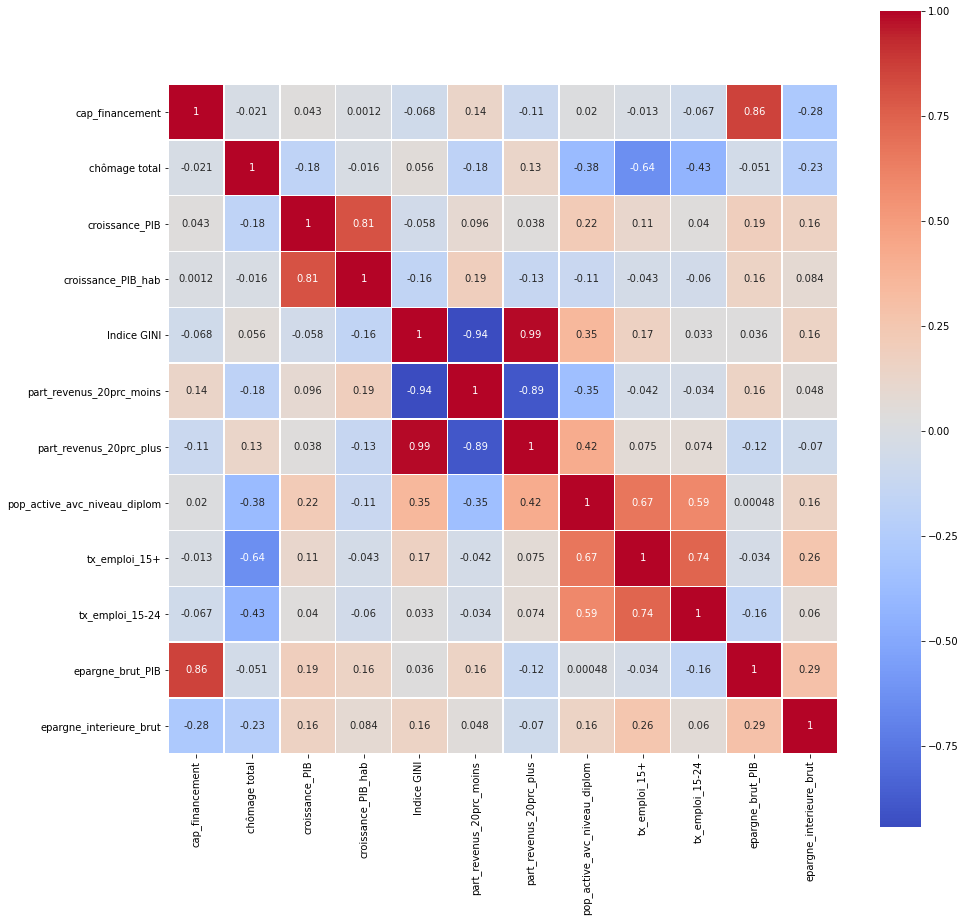

In [53]:
corrMatrix = df_eco2.corr()

plt.figure(figsize=(15,15))
sns.heatmap(corrMatrix, square=True, annot=True, linewidths=.5, cmap='coolwarm')
plt.show()

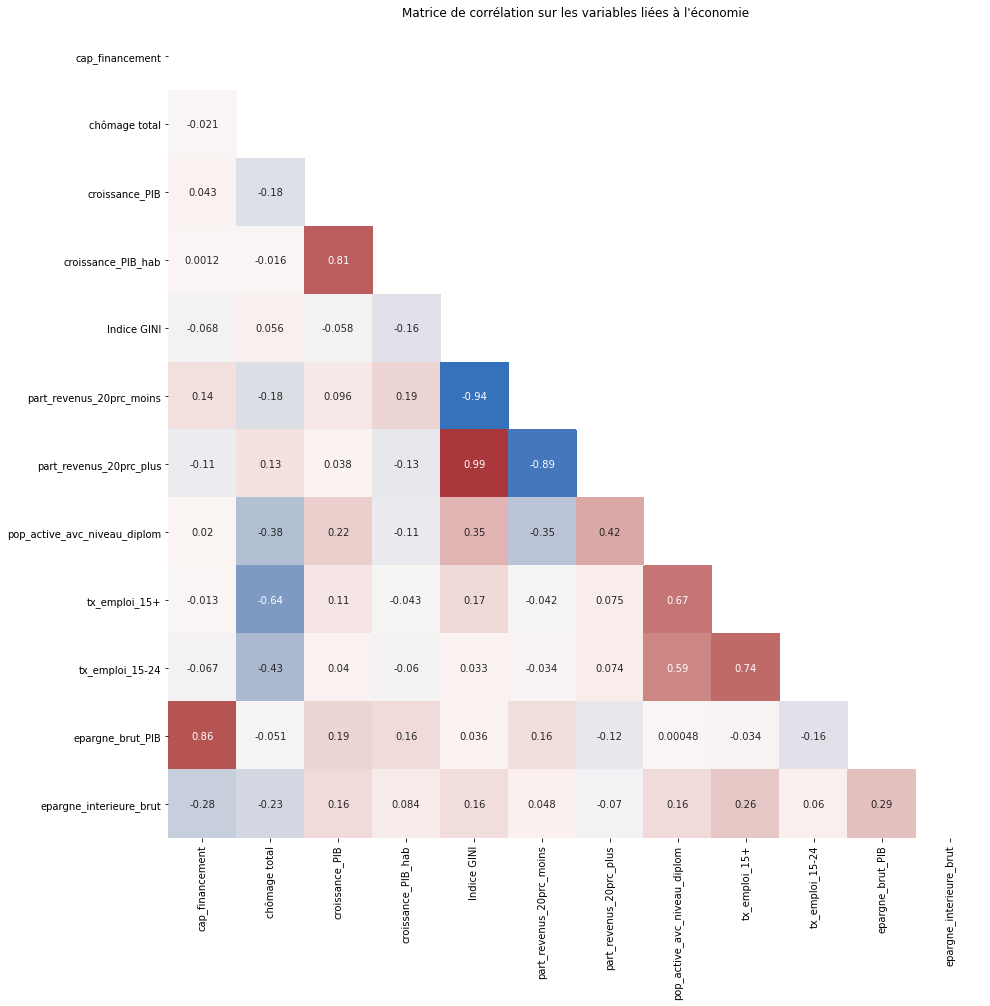

In [54]:
mask = np.triu(corrMatrix)

plt.figure(figsize=(15,15))
sns.heatmap(corrMatrix, square=True, mask = mask, fmt = '.2g', annot=True, vmin=-1, vmax=1, cmap='vlag', center= 0, cbar=False)
plt.title('Matrice de corrélation sur les variables liées à l\'économie')
plt.savefig('Corr_matrix_economie.png')
plt.show()

### Analyse en composante principale

In [55]:
# Préprocessing des data
# On n'a au préalable supprimer les variables qui n'avaient aucune corrélation avec les autres
data_acp2 = df_eco2.set_index('pays')
data_acp2.drop('code_pays', axis=1, inplace = True)

print(data_acp2.shape)
n = data_acp2.shape[0]
p = data_acp2.shape[1]

(217, 12)


In [56]:
# Remplacement des valeurs nulles par la médiane
data_acp2[data_acp2.columns] = data_acp2[data_acp2.columns].apply(pd.to_numeric, errors='coerce')
data_acp2 = data_acp2.fillna(data_acp2.median())

# Normalisation des valeurs
sc = StandardScaler()
Z = sc.fit_transform(data_acp2)

In [57]:
acp2 = PCA()
print(acp2)

PCA()


In [58]:
coord = acp2.fit_transform(Z)
print(acp2.n_components_)

12


In [59]:
# Correction de la variance expliquée
eigval = (n-1)/n*acp2.explained_variance_
print(eigval)

[2.88656286 2.442005   1.83511609 1.56652672 1.13358428 0.59313804
 0.56302132 0.39505565 0.21232753 0.14857806 0.13266308 0.09142137]


In [60]:
# proportion de valeurs expliquées
ratio = acp2.explained_variance_ratio_ * 100
print(acp2.explained_variance_ratio_)

[0.2405469  0.20350042 0.15292634 0.13054389 0.09446536 0.04942817
 0.04691844 0.0329213  0.01769396 0.0123815  0.01105526 0.00761845]


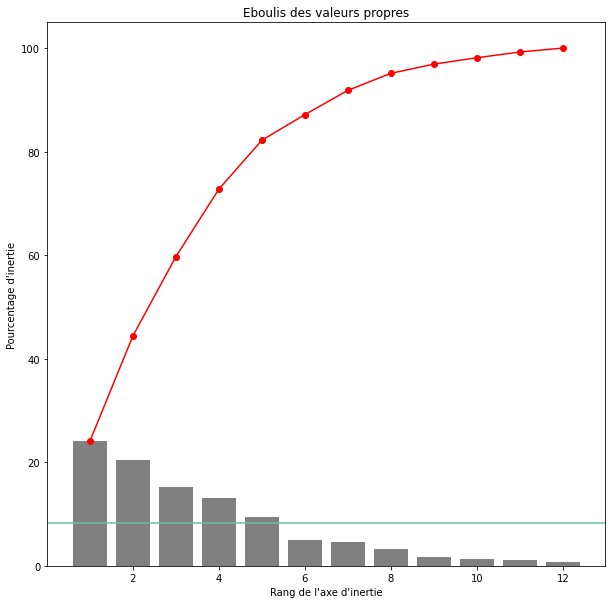

In [61]:
fig, ax = plt.subplots(figsize=(10,10))
scree = acp2.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree, color='gray')
plt.plot(np.arange(len(scree))+1, scree.cumsum(),marker='o', color='r')
plt.axhline(y=100/p)
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

Selon le critère de Kaiser, les composantes expliquant plus de 8.33% de la variance peuvent être sélectionnés. Les composantes F1, F2, F3, et F4 seront donc observées. 

In [62]:
# contribution des individus dans l'inertie totale
di = np.sum(Z**2,axis=1)
print(pd.DataFrame({'ID':data_acp2.index,'d_i':di}).sort_values('d_i', ascending=False))

                                    ID         d_i
186                        Timor-Leste  288.306194
95                              Kosovo   52.404041
176                      Soudan du Sud   47.496164
1                       Afrique du Sud   42.600421
101                            Libéria   41.966066
..                                 ...         ...
193                             Tuvalu    0.736791
47   Corée. République démocratique de    0.229413
67                           Gibraltar    0.229413
162                  Saint-Martin (fr)    0.229413
216          Îles Vierges britanniques    0.229413

[217 rows x 2 columns]


In [63]:
# qualité de représentation des individus - COS2
cos2 = coord**2

for j in range(p):
  cos2[:,j] = cos2[:,j]/di

qualite = pd.DataFrame({'id':data_acp2.index,'COS2_F1':cos2[:,0],'COS2_F2':cos2[:,1], 'COS2_F3':cos2[:,2],'COS2_F4':cos2[:,3]})

print(qualite)

                            id   COS2_F1   COS2_F2   COS2_F3   COS2_F4
0                  Afghanistan  0.015158  0.007202  0.278286  0.070221
1               Afrique du Sud  0.000539  0.763859  0.159204  0.000303
2                      Albanie  0.623468  0.049178  0.003302  0.153055
3                      Algérie  0.479486  0.068802  0.000425  0.019418
4                    Allemagne  0.196346  0.180342  0.428526  0.041553
..                         ...       ...       ...       ...       ...
212              Îles Marshall  0.203773  0.172315  0.020486  0.098623
213               Îles Salomon  0.571421  0.009759  0.102480  0.000251
214    Îles Turques-et-Caïques  0.079566  0.254582  0.000846  0.116464
215          Îles Vierges (EU)  0.000196  0.116955  0.552306  0.227322
216  Îles Vierges britanniques  0.003754  0.098993  0.325044  0.052368

[217 rows x 5 columns]


In [64]:
print(qualite.sort_values('COS2_F1', ascending=False).head(10))

                     id   COS2_F1   COS2_F2   COS2_F3   COS2_F4
35             Cameroun  0.873635  0.000554  0.001419  0.001065
147               Pérou  0.826286  0.008779  0.049783  0.005454
106          Madagascar  0.768203  0.019125  0.081731  0.013556
49              Croatie  0.768084  0.003771  0.077843  0.027065
32                Bénin  0.762632  0.005598  0.005409  0.000847
140            Paraguay  0.755412  0.067770  0.068752  0.008314
187                Togo  0.753154  0.009290  0.010709  0.000923
175              Soudan  0.713604  0.002132  0.027787  0.090289
24   Bosnie-Herzégovine  0.704784  0.061017  0.000440  0.053509
122          Mozambique  0.698101  0.006997  0.062242  0.063154


In [65]:
print(qualite.sort_values('COS2_F2', ascending=False).head(10))

                 id   COS2_F1   COS2_F2   COS2_F3   COS2_F4
31          Bélarus  0.016906  0.898904  0.024845  0.016176
92       Kazakhstan  0.009571  0.846368  0.016871  0.056833
89         Jamaïque  0.020302  0.819046  0.037669  0.024598
1    Afrique du Sud  0.000539  0.763859  0.159204  0.000303
9         Argentine  0.085215  0.748006  0.000464  0.000020
17       Bangladesh  0.020945  0.741413  0.065058  0.033756
82        Indonésie  0.059099  0.724547  0.034456  0.058938
59         Eswatini  0.030043  0.709801  0.190073  0.002906
135     Ouzbékistan  0.030465  0.705955  0.227525  0.009338
14      Azerbaïdjan  0.072840  0.681166  0.143421  0.030776


In [66]:
print(qualite.sort_values('COS2_F3', ascending=False).head(10))

                            id   COS2_F1   COS2_F2   COS2_F3   COS2_F4
5                      Andorre  0.055943  0.003793  0.678500  0.100150
150                Royaume-Uni  0.080587  0.065401  0.672849  0.000949
71                        Guam  0.000569  0.089657  0.626780  0.128917
209       Îles Anglo-Normandes  0.000534  0.077268  0.609087  0.173343
40                      Chypre  0.234236  0.072355  0.598583  0.012172
146                   Portugal  0.012869  0.116374  0.584474  0.003219
172  Sint Maarten (Dutch part)  0.000009  0.117121  0.575146  0.227004
90                       Japon  0.021339  0.103712  0.557979  0.120411
215          Îles Vierges (EU)  0.000196  0.116955  0.552306  0.227322
112                  Mariannes  0.102893  0.008853  0.535217  0.138635


In [67]:
print(qualite.sort_values('COS2_F4', ascending=False).head(10))

                               id   COS2_F1   COS2_F2   COS2_F3   COS2_F4
186                   Timor-Leste  0.084079  0.092793  0.145299  0.597813
117  Micronésie. États fédérés de  0.000032  0.205468  0.061989  0.503393
177                     Sri Lanka  0.040543  0.053668  0.166714  0.374961
109                      Maldives  0.000448  0.135638  0.004370  0.336092
94                       Kiribati  0.263717  0.039423  0.013314  0.330384
29                   Burkina Faso  0.098098  0.131653  0.003071  0.328639
77                        Géorgie  0.171735  0.001296  0.196575  0.322243
44           Congo. République du  0.050426  0.181688  0.076009  0.306580
21                       Bermudes  0.028812  0.005573  0.140026  0.296902
151                        Rwanda  0.104136  0.010004  0.382774  0.281811


In [68]:
# contribution aux axes
ctr = coord**2
for j in range(p):
  ctr[:,j] = ctr[:,j]/(n*eigval[j]) # eigval = c. 40 (variance expliquée et corrigé)

contribution = pd.DataFrame({'id':data_acp2.index,'CTR_F1':ctr[:,0],'CTR_F2':ctr[:,1], 'CTR_F3':ctr[:,2],'CTR_F4':ctr[:,3]})
print(contribution)

                            id    CTR_F1    CTR_F2    CTR_F3    CTR_F4
0                  Afghanistan  0.000153  0.000086  0.004431  0.001310
1               Afrique du Sud  0.000037  0.061407  0.017031  0.000038
2                      Albanie  0.006752  0.000630  0.000056  0.003054
3                      Algérie  0.014811  0.002512  0.000021  0.001105
4                    Allemagne  0.002009  0.002182  0.006898  0.000784
..                         ...       ...       ...       ...       ...
212              Îles Marshall  0.004213  0.004211  0.000666  0.003757
213               Îles Salomon  0.019694  0.000398  0.005556  0.000016
214    Îles Turques-et-Caïques  0.000167  0.000632  0.000003  0.000451
215          Îles Vierges (EU)  0.000003  0.001867  0.011730  0.005656
216  Îles Vierges britanniques  0.000001  0.000043  0.000187  0.000035

[217 rows x 5 columns]


In [69]:
print(contribution.sort_values('CTR_F1', ascending=False).head(10))

                      id    CTR_F1    CTR_F2        CTR_F3    CTR_F4
95                Kosovo  0.056811  0.003161  3.626320e-03  0.007033
186          Timor-Leste  0.038699  0.050485  1.051949e-01  0.507016
106           Madagascar  0.029519  0.000869  4.939987e-03  0.000960
148                Qatar  0.024359  0.021517  2.036147e-03  0.001273
24    Bosnie-Herzégovine  0.024016  0.002458  2.360921e-05  0.003360
34              Cambodge  0.023234  0.008612  3.344393e-03  0.003386
54              Djibouti  0.019949  0.007888  2.916930e-02  0.006694
213         Îles Salomon  0.019694  0.000398  5.555519e-03  0.000016
147                Pérou  0.018464  0.000232  1.749854e-03  0.000225
41   Cisjordanie et Gaza  0.017881  0.004702  2.161176e-07  0.002563


In [70]:
print(contribution.sort_values('CTR_F2', ascending=False).head(10))

                 id    CTR_F1    CTR_F2    CTR_F3    CTR_F4
1    Afrique du Sud  0.000037  0.061407  0.017031  0.000038
186     Timor-Leste  0.038699  0.050485  0.105195  0.507016
124         Namibie  0.001714  0.033912  0.016739  0.000005
207        Éthiopie  0.009394  0.031635  0.001255  0.005995
14      Azerbaïdjan  0.002831  0.031288  0.008766  0.002204
59         Eswatini  0.001056  0.029488  0.010508  0.000188
176   Soudan du Sud  0.006764  0.024610  0.044435  0.024045
97          Lesotho  0.003000  0.023549  0.008986  0.000402
123         Myanmar  0.000614  0.022959  0.010359  0.013667
148           Qatar  0.024359  0.021517  0.002036  0.001273


In [71]:
print(contribution.sort_values('CTR_F3', ascending=False).head(10))

                                                 id    CTR_F1    CTR_F2  \
186                                     Timor-Leste  0.038699  0.050485   
176                                   Soudan du Sud  0.006764  0.024610   
101                                         Libéria  0.002018  0.002012   
54                                         Djibouti  0.019949  0.007888   
100                                           Libye  0.004304  0.000547   
25                                         Botswana  0.003548  0.017672   
38                                            Chine  0.003277  0.015320   
152  Région administrative spéciale de Macao. Chine  0.001565  0.019003   
112                                       Mariannes  0.002087  0.000212   
1                                    Afrique du Sud  0.000037  0.061407   

       CTR_F3    CTR_F4  
186  0.105195  0.507016  
176  0.044435  0.024045  
101  0.032779  0.003347  
54   0.029169  0.006694  
100  0.026086  0.000220  
25   0.024587  0.0

In [72]:
print(contribution.sort_values('CTR_F4', ascending=False).head(10))

                       id    CTR_F1    CTR_F2    CTR_F3    CTR_F4
186           Timor-Leste  0.038699  0.050485  0.105195  0.507016
94               Kiribati  0.017448  0.003083  0.001386  0.040277
176         Soudan du Sud  0.006764  0.024610  0.044435  0.024045
26      Brunéi Darussalam  0.001718  0.000420  0.000488  0.015283
129               Norvège  0.000137  0.015786  0.006374  0.013937
123               Myanmar  0.000614  0.022959  0.010359  0.013667
44   Congo. République du  0.001140  0.004855  0.002703  0.012770
10                Arménie  0.010871  0.001844  0.003230  0.012601
182           Tadjikistan  0.008894  0.002640  0.001436  0.011298
161           Saint-Marin  0.011757  0.000852  0.007501  0.010205


In [73]:
#racine carrée des valeurs propres
sqrt_eigval = np.sqrt(eigval)

#corrélation des variables avec les axes
corvar = np.zeros((p,p))
for k in range(p):
  corvar[:,k] = acp2.components_[k,:] * sqrt_eigval[k]

In [74]:
#on affiche pour les quatre premiers axes
print(pd.DataFrame({'id':data_acp2.columns,'COR_1':corvar[:,0],'COR_2':corvar[:,1], 'COR_3':corvar[:,2],'COR_4':corvar[:,3]}))

                              id     COR_1     COR_2     COR_3     COR_4
0                cap_financement  0.169913 -0.287390  0.348036  0.786659
1                  chômage total  0.499556  0.565777  0.213587 -0.042776
2                 croissance_PIB -0.103531 -0.470577  0.677568 -0.454597
3             croissance_PIB_hab  0.131720 -0.446718  0.631539 -0.519812
4                    Indice GINI -0.448572  0.427856  0.314404  0.120964
5       part_revenus_20prc_moins  0.500237 -0.704629 -0.344083 -0.026929
6        part_revenus_20prc_plus -0.532321  0.642046  0.414750 -0.001818
7   pop_active_avc_niveau_diplom -0.814339 -0.114073  0.070360  0.116269
8                  tx_emploi_15+ -0.786882 -0.431951 -0.199347  0.069943
9                tx_emploi_15-24 -0.699741 -0.330528 -0.286411 -0.000511
10              epargne_brut_PIB  0.157239 -0.383137  0.527667  0.651566
11       epargne_interieure_brut -0.220355 -0.266244  0.126544 -0.103400


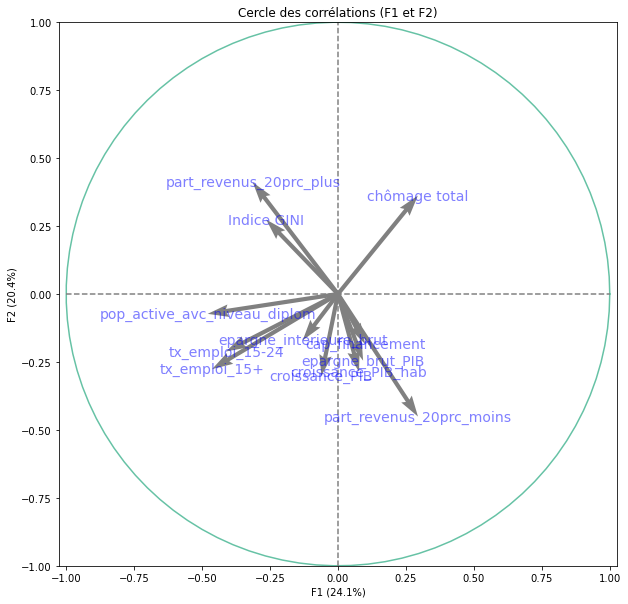

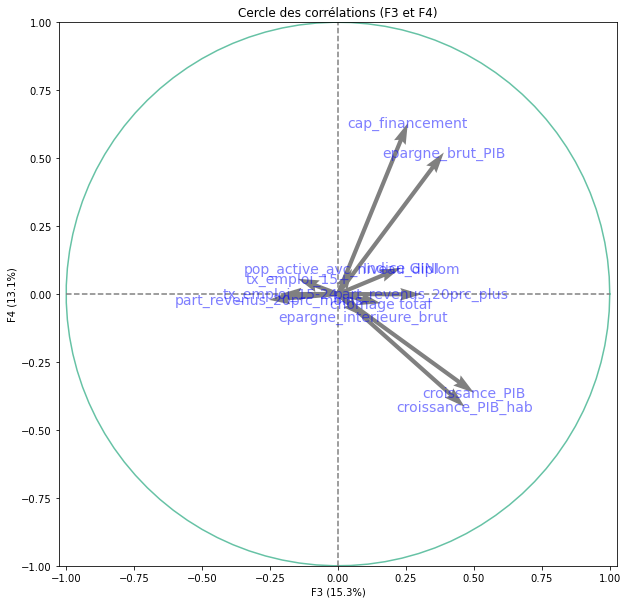

In [75]:
pcs2 = acp2.components_
features = data_acp2.columns
display_circles(pcs2, p, acp2, [(0,1), (2,3)], labels = np.array(features))

In [76]:
#cosinus carré des variables
cos2var = corvar**2
#print(pd.DataFrame({'id':data_acp2.columns,'COS2_1':cos2var[:,0],'COS2_2':cos2var[:,1], 'COS2_3':cos2var[:,2],'COS2_4':cos2var[:,3], 'COS2_5':cos2var[:,4],'COS2_6':cos2var[:,5]}))

In [77]:
#contributions
ctrvar = cos2var
for k in range(p):
  ctrvar[:,k] = ctrvar[:,k]/eigval[k]

#on n'affiche que pour les six premiers axes
print(pd.DataFrame({'id':data_acp2.columns,'CTR_1':ctrvar[:,0],'CTR_2':ctrvar[:,1], 'CTR_3':ctrvar[:,2],'CTR_4':ctrvar[:,3]}))

                              id     CTR_1     CTR_2     CTR_3         CTR_4
0                cap_financement  0.010002  0.033822  0.066006  3.950350e-01
1                  chômage total  0.086454  0.131082  0.024859  1.168045e-03
2                 croissance_PIB  0.003713  0.090681  0.250174  1.319214e-01
3             croissance_PIB_hab  0.006011  0.081719  0.217338  1.724865e-01
4                    Indice GINI  0.069708  0.074963  0.053866  9.340649e-03
5       part_revenus_20prc_moins  0.086690  0.203317  0.064515  4.629246e-04
6        part_revenus_20prc_plus  0.098167  0.168805  0.093737  2.110389e-06
7   pop_active_avc_niveau_diplom  0.229736  0.005329  0.002698  8.629569e-03
8                  tx_emploi_15+  0.214505  0.076405  0.021655  3.122834e-03
9                tx_emploi_15-24  0.169626  0.044737  0.044701  1.665361e-07
10              epargne_brut_PIB  0.008565  0.060112  0.151725  2.710058e-01
11       epargne_interieure_brut  0.016822  0.029028  0.008726  6.824981e-03

- F1 : Indice de GINI, Revenus détenus par les 20% les moins élevés, Revenus détenus par les 20% les plus élevés, Population active avec diplôme de base, Population de 0 à 14 ans 
- F2 : Chômage total, PIB par habitant,Taux d'emploi des 15 ans et plus, Taux d'actifs des 15-24 ans,  Epargne intérieure brute
- F3 : Croissance PIB, Croissance PIB par habitant, 
- F4 : Capacité/Besoin de financement, Epargne brute (PIB)

## Conclusion

In [78]:
df_eco2.columns = ['pays', 'code_pays', 'capacite_financement', 'chomage_total', 'croissance_pib', 'croissance_pib_hab', 'indice_gini', 'revenus_20prc_moins_eleves', 'revenus_20prc_plus_eleves', 'pop_active_avec_diplome', 'tx_emploi_15+', 'tx_actifs_15-24', 'epargne_brute(PIB)', 'epargne_interieure_brute']

cols_num2 = ['capacite_financement', 'chomage_total', 'croissance_pib', 'croissance_pib_hab', 'indice_gini', 'revenus_20prc_moins_eleves', 'revenus_20prc_plus_eleves', 'pop_active_avec_diplome', 'tx_emploi_15+', 'tx_actifs_15-24', 'epargne_brute(PIB)', 'epargne_interieure_brute']

# Remplacement des valeurs nulles par la médiane
df_eco2[cols_num2] = df_eco2[cols_num2].fillna(df_eco2[cols_num2].median())                   
                   
df_eco2.to_csv('df_eco_clean.csv')
df_eco2.to_excel('df_eco_clean.xlsx')

In [79]:
df_eco2.head()

,pays,code_pays,capacite_financement,chomage_total,croissance_pib,croissance_pib_hab,indice_gini,revenus_20prc_moins_eleves,revenus_20prc_plus_eleves,pop_active_avec_diplome,tx_emploi_15+,tx_actifs_15-24,epargne_brute(PIB),epargne_interieure_brute
0,Afghanistan,AFG,-0.461142,5.817500,6.664775,3.452640,65.500000,6.566667,44.800000,49.745001,49.372499,45.339999,20.896559,19.719900
1,Afrique du Sud,ZAF,-3.156518,27.014737,2.558669,1.144181,63.550000,2.525000,69.200000,43.265556,38.091579,27.254737,16.371788,19.719900
2,Albanie,ALB,-3.236472,14.582632,4.117023,4.555113,31.962500,8.012500,40.087500,45.808462,47.963571,34.666428,21.311708,9.391536
3,Algérie,DZA,-1.840846,14.311176,3.252632,1.493450,27.600000,9.400000,37.200000,52.174000,34.886250,25.401429,47.290134,45.964392
4,Allemagne,DEU,-0.606787,6.815263,1.266693,1.210430,30.878571,8.300000,39.364286,38.054737,55.450000,50.402631,26.247102,26.142249


# Corrélation entre situation économique et éducation

In [80]:
df = pd.merge(df_edu2, df_eco2, on=['pays', 'code_pays']).reset_index()
df.drop('index', axis=1, inplace=True)
df.head()

,pays,code_pays,acces_ens_secondaire,ados_non-scol,enfants_non-scol,inscriptions_ens_sup,inscriptions_primaire,inscriptions_préscol,inscriptions_secondaire,ratio_ens_sup,...,croissance_pib,croissance_pib_hab,indice_gini,revenus_20prc_moins_eleves,revenus_20prc_plus_eleves,pop_active_avec_diplome,tx_emploi_15+,tx_actifs_15-24,epargne_brute(PIB),epargne_interieure_brute
0,Afghanistan,AFG,89.783073,7.781353,3.996940,4.619342,94.895554,3.080470,39.700971,0.294833,...,6.664775,3.452640,65.500000,6.566667,44.800000,49.745001,49.372499,45.339999,20.896559,19.719900
1,Afrique du Sud,ZAF,96.816158,13.785806,7.176252,20.994972,104.268580,22.914647,94.457259,1.296527,...,2.558669,1.144181,63.550000,2.525000,69.200000,43.265556,38.091579,27.254737,16.371788,19.719900
2,Albanie,ALB,98.833753,4.755447,6.472873,41.650427,100.335247,66.300319,86.715374,1.308677,...,4.117023,4.555113,31.962500,8.012500,40.087500,45.808462,47.963571,34.666428,21.311708,9.391536
3,Algérie,DZA,96.591529,7.781353,2.718592,29.798487,111.345440,35.694609,80.699898,1.299649,...,3.252632,1.493450,27.600000,9.400000,37.200000,52.174000,34.886250,25.401429,47.290134,45.964392
4,Allemagne,DEU,99.627867,2.639915,2.280481,67.467917,102.896194,108.693307,101.335926,0.985777,...,1.266693,1.210430,30.878571,8.300000,39.364286,38.054737,55.450000,50.402631,26.247102,26.142249


In [81]:
del df_edu
del df_edu2
del df_eco
del df_eco2

In [82]:
df.to_csv('df_final.csv')
df.to_excel('df_final.xlsx')

## Matrice de corrélation

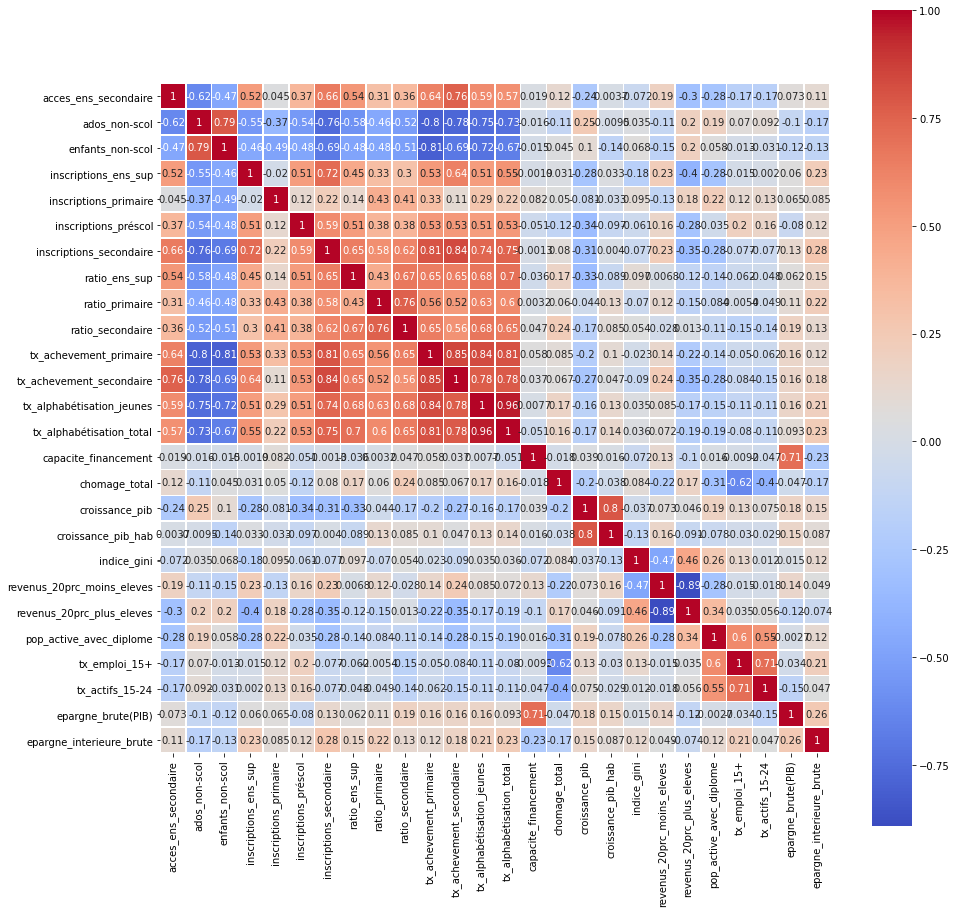

In [83]:
corrMatrix = df.corr()

plt.figure(figsize=(15,15))
sns.heatmap(corrMatrix, square=True, annot=True, linewidths=.5, cmap='coolwarm')
plt.show()

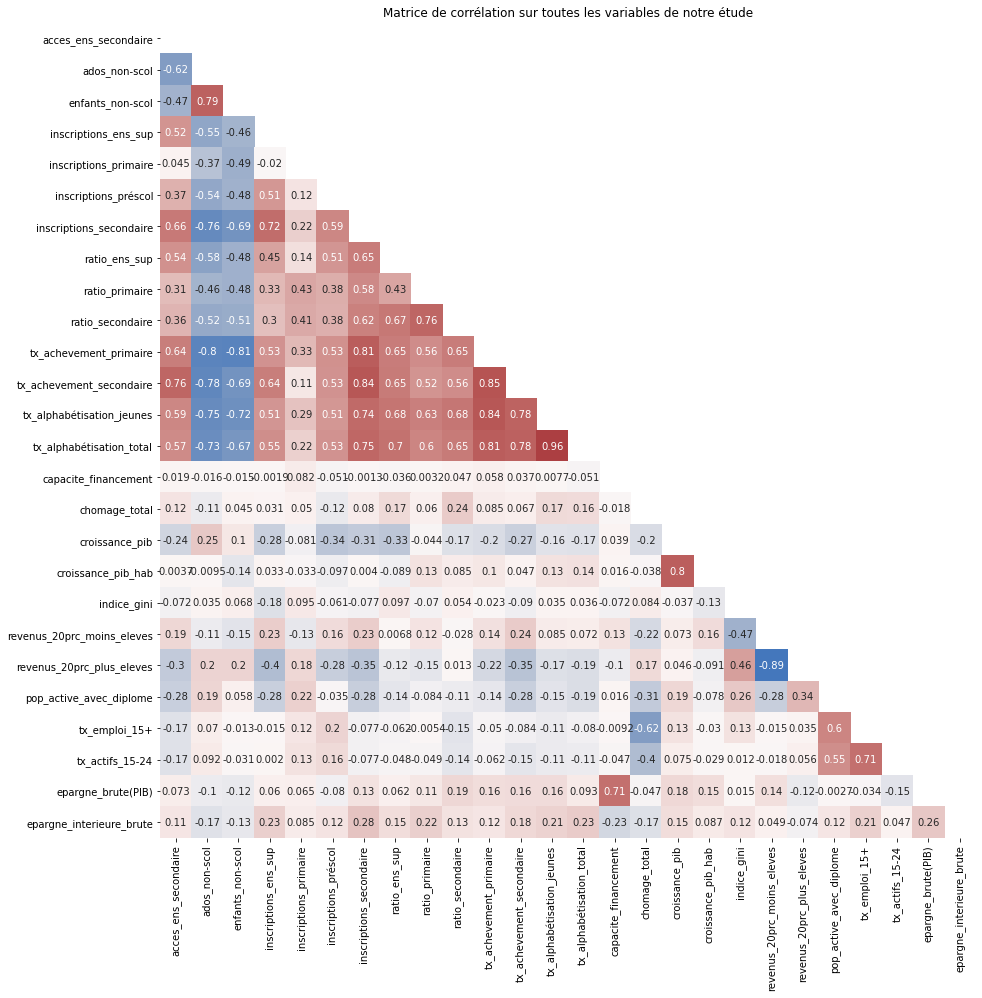

In [84]:
mask = np.triu(corrMatrix)

plt.figure(figsize=(15,15))
sns.heatmap(corrMatrix, square=True, mask = mask, fmt = '.2g', annot=True, vmin=-1, vmax=1, cmap='vlag', center= 0, cbar=False)
plt.title('Matrice de corrélation sur toutes les variables de notre étude')
plt.savefig('Corr_Matrix_total.png')
plt.show()

## Analyses en composantes principales

In [85]:
data_acp3 = df.set_index('pays')
data_acp3.drop('code_pays', axis=1, inplace = True)

print(data_acp3.shape)
n = data_acp3.shape[0]
p = data_acp3.shape[1]

(204, 26)


In [86]:
sc = StandardScaler()
Z = sc.fit_transform(data_acp3)

In [87]:
acp3 = PCA()
coord = acp3.fit_transform(Z)
print(acp3.n_components_)

26


In [88]:
#valeur corrigée
eigval = (n-1)/n*acp3.explained_variance_
print(eigval)

[8.90524891 2.8975953  2.65823133 2.12829857 1.5956969  1.24792061
 1.00734424 0.8197878  0.6508628  0.56921261 0.53648748 0.46539162
 0.39047701 0.38241316 0.30906513 0.26793498 0.22418205 0.18328881
 0.14813621 0.1403058  0.10441937 0.09948571 0.08918806 0.08210236
 0.07049784 0.02642535]


In [89]:
# proportion de valeurs expliquées
ratio = acp3.explained_variance_ratio_ * 100
print(acp3.explained_variance_ratio_)

[0.34250957 0.11144597 0.10223967 0.08185764 0.06137296 0.04799695
 0.03874401 0.0315303  0.02503318 0.02189279 0.02063413 0.01789968
 0.01501835 0.0147082  0.01188712 0.01030519 0.00862239 0.00704957
 0.00569755 0.00539638 0.00401613 0.00382637 0.00343031 0.00315778
 0.00271146 0.00101636]


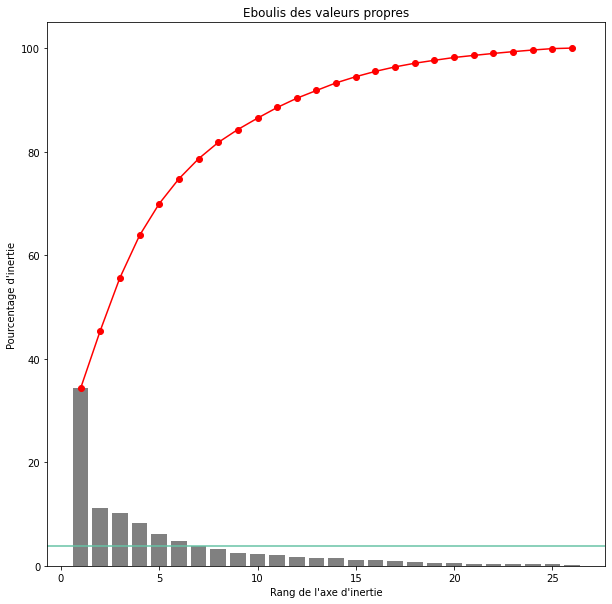

In [90]:
fig, ax = plt.subplots(figsize=(10,10))
scree = acp3.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree, color='gray')
plt.plot(np.arange(len(scree))+1, scree.cumsum(),marker='o', color='r')
plt.axhline(y=100/p)
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

Selon le critère de Kaiser, il est intéressant de conserver les composantes qui expliquent plus de 3,7% de la variance. Les composantes F1, F2, F3, F4, F5 et F6 seront donc conservées. 

In [91]:
# contribution des individus dans l'inertie totale
di = np.sum(Z**2,axis=1)
print(pd.DataFrame({'ID':data_acp3.index,'d_i':di}))

                            ID        d_i
0                  Afghanistan  71.878455
1               Afrique du Sud  45.374308
2                      Albanie  10.443188
3                      Algérie  21.925439
4                    Allemagne  13.564584
..                         ...        ...
199                 Îles Féroé   2.314025
200              Îles Marshall  16.975343
201               Îles Salomon  25.929486
202    Îles Turques-et-Caïques   9.397042
203  Îles Vierges britanniques   6.150645

[204 rows x 2 columns]


In [92]:
# qualité de représentation des individus - COS2
cos2 = coord**2

for j in range(p):
  cos2[:,j] = cos2[:,j]/di

qualite = pd.DataFrame({'id':data_acp3.index,'COS2_F1':cos2[:,0],'COS2_F2':cos2[:,1], 'COS2_F3':cos2[:,2], 'COS2_F4':cos2[:,3], 'COS2_F5':cos2[:,4], 'COS2_F6':cos2[:,5]})

print(qualite)

                            id   COS2_F1   COS2_F2   COS2_F3   COS2_F4  \
0                  Afghanistan  0.438686  0.014650  0.013136  0.000005   
1               Afrique du Sud  0.002446  0.000307  0.829353  0.030851   
2                      Albanie  0.369454  0.297762  0.014912  0.021593   
3                      Algérie  0.073203  0.275221  0.011268  0.050823   
4                    Allemagne  0.428563  0.046443  0.163291  0.174600   
..                         ...       ...       ...       ...       ...   
199                 Îles Féroé  0.484456  0.015896  0.041960  0.000013   
200              Îles Marshall  0.009044  0.153947  0.163821  0.001887   
201               Îles Salomon  0.082049  0.433218  0.024858  0.106516   
202    Îles Turques-et-Caïques  0.001388  0.004303  0.023447  0.001057   
203  Îles Vierges britanniques  0.604705  0.022197  0.000741  0.041491   

      COS2_F5   COS2_F6  
0    0.000366  0.035412  
1    0.007885  0.020364  
2    0.084321  0.039816  
3    0.

In [93]:
print(qualite.sort_values('COS2_F1', ascending=False).head(10))

                            id   COS2_F1   COS2_F2   COS2_F3   COS2_F4  \
51               Côte d'Ivoire  0.900713  0.003111  0.003099  0.019820   
174                      Tchad  0.876993  0.016044  0.025668  0.000833   
146  République centrafricaine  0.873085  0.010736  0.015430  0.034727   
106                       Mali  0.870250  0.025009  0.031537  0.017217   
28                Burkina Faso  0.869027  0.015871  0.022365  0.003194   
121                      Niger  0.853720  0.030872  0.031124  0.012891   
70                      Guinée  0.849864  0.039190  0.022220  0.031841   
171                    Sénégal  0.747755  0.052497  0.000017  0.000104   
116                 Mozambique  0.743777  0.143871  0.007059  0.002539   
31                       Bénin  0.714667  0.063141  0.018776  0.009398   

          COS2_F5   COS2_F6  
51   1.820176e-04  0.024365  
174  2.074975e-03  0.025794  
146  9.840759e-03  0.025875  
106  3.240386e-05  0.006353  
28   6.703675e-03  0.001857  
121  

In [94]:
print(qualite.sort_values('COS2_F2', ascending=False).head(10))

                              id   COS2_F1   COS2_F2   COS2_F3   COS2_F4  \
139                        Pérou  0.057279  0.718132  0.006171  0.007920   
88                      Jordanie  0.006267  0.637215  0.048788  0.000010   
133                     Paraguay  0.000118  0.624098  0.123984  0.028142   
192  Égypte. République arabe d’  0.003867  0.583900  0.015600  0.000175   
194                     Équateur  0.083446  0.565871  0.111765  0.011571   
22                       Bolivie  0.021697  0.519970  0.107730  0.010133   
40           Cisjordanie et Gaza  0.078732  0.499007  0.122533  0.001643   
23            Bosnie-Herzégovine  0.092616  0.495448  0.087365  0.018522   
113                      Moldova  0.163982  0.441250  0.033699  0.025251   
201                 Îles Salomon  0.082049  0.433218  0.024858  0.106516   

      COS2_F5   COS2_F6  
139  0.009112  0.000448  
88   0.023939  0.004022  
133  0.000202  0.015940  
192  0.072463  0.081654  
194  0.000184  0.004349  
22   0.

In [95]:
print(qualite.sort_values('COS2_F3', ascending=False).head(10))

                 id   COS2_F1   COS2_F2   COS2_F3   COS2_F4   COS2_F5  \
1    Afrique du Sud  0.002446  0.000307  0.829353  0.030851  0.007885   
118         Namibie  0.009894  0.040354  0.780322  0.097349  0.001584   
58         Eswatini  0.050504  0.025535  0.706204  0.062885  0.003587   
93          Lesotho  0.029539  0.014238  0.509263  0.091975  0.010788   
30          Bélarus  0.438663  0.000127  0.503041  0.001818  0.005308   
24         Botswana  0.002182  0.060816  0.498043  0.178550  0.000088   
86         Jamaïque  0.056996  0.001905  0.459969  0.146510  0.003969   
32       Cabo Verde  0.040800  0.042098  0.411003  0.234019  0.000117   
13      Azerbaïdjan  0.053518  0.043044  0.393947  0.337740  0.025260   
89       Kazakhstan  0.372506  0.000201  0.393532  0.093297  0.030319   

      COS2_F6  
1    0.020364  
118  0.001124  
58   0.001933  
93   0.123062  
30   0.000518  
24   0.065863  
86   0.010410  
32   0.000068  
13   0.004588  
89   0.000139  


In [96]:
print(qualite.sort_values('COS2_F4', ascending=False).head(10))

                id   COS2_F1   COS2_F2   COS2_F3   COS2_F4   COS2_F5   COS2_F6
37           Chine  0.039336  0.090917  0.182944  0.366690  0.101777  0.058446
128    Ouzbékistan  0.058771  0.013299  0.260106  0.356031  0.009705  0.000798
181   Turkménistan  0.023055  0.074167  0.042034  0.352021  0.190424  0.027755
96           Libye  0.089814  0.069602  0.067002  0.345115  0.001740  0.180921
13     Azerbaïdjan  0.053518  0.043044  0.393947  0.337740  0.025260  0.004588
21         Bhoutan  0.218108  0.001627  0.123045  0.317781  0.056198  0.004432
135    Philippines  0.077002  0.246281  0.016709  0.295235  0.008651  0.016361
166  Soudan du Sud  0.460217  0.002497  0.036294  0.288011  0.059588  0.060437
117        Myanmar  0.174274  0.016370  0.216717  0.286530  0.105745  0.010929
97         Libéria  0.300935  0.001476  0.003037  0.277132  0.000009  0.172501


In [97]:
print(qualite.sort_values('COS2_F5', ascending=False).head(10))

                               id   COS2_F1   COS2_F2   COS2_F3   COS2_F4  \
176                   Timor-Leste  0.001355  0.052564  0.030892  0.222053   
91                       Kiribati  0.104468  0.147856  0.073292  0.036468   
112  Micronésie. États fédérés de  0.043052  0.001114  0.228710  0.019885   
181                  Turkménistan  0.023055  0.074167  0.042034  0.352021   
9                         Arménie  0.164926  0.289008  0.019909  0.139842   
123                       Norvège  0.365471  0.000055  0.335554  0.052925   
74                        Géorgie  0.367763  0.054556  0.001732  0.140334   
167                     Sri Lanka  0.353301  0.004556  0.002872  0.091683   
141                      Roumanie  0.373333  0.121683  0.004024  0.016748   
172                   Tadjikistan  0.003788  0.253070  0.066154  0.109986   

      COS2_F5   COS2_F6  
176  0.653730  0.001638  
91   0.338753  0.146165  
112  0.299658  0.000319  
181  0.190424  0.027755  
9    0.189083  0.03700

In [98]:
print(qualite.sort_values('COS2_F6', ascending=False).head(10))

                            id   COS2_F1   COS2_F2   COS2_F3   COS2_F4  \
92                      Koweït  0.224839  0.094568  0.000666  0.001707   
15                     Bahreïn  0.219778  0.088508  0.004605  0.002284   
14                     Bahamas  0.011879  0.018104  0.114730  0.051974   
104                     Malawi  0.279469  0.215555  0.000820  0.001121   
25           Brunéi Darussalam  0.218178  0.070195  0.033684  0.000730   
71          Guinée équatoriale  0.268982  0.000611  0.005898  0.028627   
161                  Singapour  0.155462  0.167890  0.021731  0.069033   
132  Papouasie-Nouvelle-Guinée  0.294822  0.058177  0.006857  0.023931   
191                   Zimbabwe  0.099154  0.205123  0.052693  0.216379   
143                     Rwanda  0.300378  0.078382  0.028443  0.226431   

      COS2_F5   COS2_F6  
92   0.040319  0.307330  
15   0.035819  0.298190  
14   0.026734  0.295565  
104  0.000230  0.281919  
25   0.101371  0.277948  
71   0.049094  0.253944  
161

In [99]:
# contribution aux axes
ctr = coord**2
for j in range(p):
  ctr[:,j] = ctr[:,j]/(n*eigval[j]) # eigval = c. 40 (variance expliquée et corrigé)

contribution = pd.DataFrame({'id':data_acp3.index,'CTR_F1':ctr[:,0],'CTR_F2':ctr[:,1], 'CTR_F3':ctr[:,2],'CTR_F4':ctr[:,3], 'CTR_F5':ctr[:,4],'CTR_F6':ctr[:,5]})
print(contribution)

                            id    CTR_F1    CTR_F2    CTR_F3        CTR_F4  \
0                  Afghanistan  0.017357  0.001781  0.001741  7.720861e-07   
1               Afrique du Sud  0.000061  0.000024  0.069395  3.224186e-03   
2                      Albanie  0.002124  0.005261  0.000287  5.193715e-04   
3                      Algérie  0.000883  0.010208  0.000456  2.566547e-03   
4                    Allemagne  0.003200  0.001066  0.004085  5.454927e-03   
..                         ...       ...       ...       ...           ...   
199                 Îles Féroé  0.000617  0.000062  0.000179  6.831100e-08   
200              Îles Marshall  0.000085  0.004421  0.005128  7.378345e-05   
201               Îles Salomon  0.001171  0.019003  0.001189  6.361312e-03   
202    Îles Turques-et-Caïques  0.000007  0.000068  0.000406  2.287136e-05   
203  Îles Vierges britanniques  0.002047  0.000231  0.000008  5.877711e-04   

       CTR_F5    CTR_F6  
0    0.000081  0.009999  
1    0.0010

In [100]:
print(contribution.sort_values('CTR_F1', ascending=False).head(10))

                            id    CTR_F1    CTR_F2    CTR_F3    CTR_F4  \
121                      Niger  0.054064  0.006009  0.006603  0.003416   
174                      Tchad  0.051107  0.002874  0.005011  0.000203   
146  République centrafricaine  0.048723  0.001841  0.002885  0.008109   
166              Soudan du Sud  0.037827  0.000631  0.009994  0.099052   
70                      Guinée  0.036394  0.005158  0.003188  0.005705   
28                Burkina Faso  0.035380  0.001986  0.003050  0.000544   
106                       Mali  0.030800  0.002720  0.003739  0.002550   
197                   Éthiopie  0.025945  0.001399  0.034580  0.001336   
116                 Mozambique  0.021808  0.012964  0.000693  0.000311   
51               Côte d'Ivoire  0.020729  0.000220  0.000239  0.001909   

           CTR_F5    CTR_F6  
121  3.171636e-07  0.008453  
174  6.748335e-04  0.010727  
146  3.064797e-03  0.010304  
166  2.733358e-02  0.035449  
70   7.532507e-04  0.000273  
28   

In [101]:
print(contribution.sort_values('CTR_F2', ascending=False).head(10))

                      id    CTR_F1    CTR_F2    CTR_F3    CTR_F4    CTR_F5  \
53              Djibouti  0.011201  0.040726  0.010401  0.016374  0.014493   
102           Madagascar  0.010030  0.032770  0.000281  0.000717  0.003527   
140                Qatar  0.000882  0.027311  0.012330  0.003343  0.000542   
189       Yémen. Rép. du  0.011687  0.025879  0.002236  0.011982  0.005100   
176          Timor-Leste  0.000208  0.024802  0.015889  0.142650  0.560136   
33              Cambodge  0.007298  0.022883  0.007521  0.005711  0.002503   
23    Bosnie-Herzégovine  0.001293  0.021265  0.004087  0.001082  0.002311   
139                Pérou  0.000521  0.020057  0.000188  0.000301  0.000462   
40   Cisjordanie et Gaza  0.000986  0.019200  0.005139  0.000086  0.001933   
201         Îles Salomon  0.001171  0.019003  0.001189  0.006361  0.000433   

       CTR_F6  
53   0.018371  
102  0.018006  
140  0.016231  
189  0.002790  
176  0.001795  
33   0.000961  
23   0.010586  
139  0.000029

In [102]:
print(contribution.sort_values('CTR_F3', ascending=False).head(10))

                 id    CTR_F1    CTR_F2    CTR_F3    CTR_F4    CTR_F5  \
1    Afrique du Sud  0.000061  0.000024  0.069395  0.003224  0.001099   
118         Namibie  0.000165  0.002067  0.043576  0.006790  0.000147   
93          Lesotho  0.000680  0.001007  0.039267  0.008858  0.001386   
58         Eswatini  0.000782  0.001215  0.036632  0.004074  0.000310   
197        Éthiopie  0.025945  0.001399  0.034580  0.001336  0.002785   
24         Botswana  0.000034  0.002893  0.025827  0.011564  0.000008   
83          Islande  0.003955  0.006117  0.020851  0.009208  0.000626   
30          Bélarus  0.005296  0.000005  0.020346  0.000092  0.000358   
13      Azerbaïdjan  0.000803  0.001985  0.019800  0.021202  0.002115   
42          Comores  0.006774  0.003497  0.017227  0.000003  0.000079   

       CTR_F6  
1    0.003630  
118  0.000134  
93   0.020212  
58   0.000214  
197  0.001262  
24   0.007275  
83   0.000824  
30   0.000045  
13   0.000491  
42   0.000548  


In [103]:
print(contribution.sort_values('CTR_F4', ascending=False).head(10))

                id    CTR_F1    CTR_F2    CTR_F3    CTR_F4    CTR_F5    CTR_F6
176    Timor-Leste  0.000208  0.024802  0.015889  0.142650  0.560136  0.001795
166  Soudan du Sud  0.037827  0.000631  0.009994  0.099052  0.027334  0.035449
97         Libéria  0.012173  0.000183  0.000412  0.046904  0.000002  0.049792
117        Myanmar  0.003361  0.000970  0.014003  0.023124  0.011383  0.001504
96           Libye  0.001437  0.003423  0.003592  0.023109  0.000155  0.020661
37           Chine  0.000590  0.004194  0.009199  0.023030  0.008526  0.006260
13     Azerbaïdjan  0.000803  0.001985  0.019800  0.021202  0.002115  0.000491
164        Somalie  0.005005  0.015307  0.001172  0.019097  0.000361  0.017174
181   Turkménistan  0.000270  0.002672  0.001651  0.017269  0.012460  0.002322
53        Djibouti  0.011201  0.040726  0.010401  0.016374  0.014493  0.018371


In [104]:
print(contribution.sort_values('CTR_F5', ascending=False).head(10))

                       id    CTR_F1    CTR_F2    CTR_F3    CTR_F4    CTR_F5  \
176           Timor-Leste  0.000208  0.024802  0.015889  0.142650  0.560136   
91               Kiribati  0.002721  0.011837  0.006396  0.003975  0.049246   
166         Soudan du Sud  0.037827  0.000631  0.009994  0.099052  0.027334   
53               Djibouti  0.011201  0.040726  0.010401  0.016374  0.014493   
123               Norvège  0.005345  0.000002  0.016440  0.003239  0.014262   
181          Turkménistan  0.000270  0.002672  0.001651  0.017269  0.012460   
9                 Arménie  0.001798  0.009682  0.000727  0.006378  0.011503   
117               Myanmar  0.003361  0.000970  0.014003  0.023124  0.011383   
172           Tadjikistan  0.000051  0.010511  0.002995  0.006219  0.009710   
43   Congo. République du  0.007253  0.000315  0.006287  0.001354  0.009093   

       CTR_F6  
176  0.001795  
91   0.027170  
166  0.035449  
53   0.018371  
123  0.000809  
181  0.002322  
9    0.002879  
11

In [105]:
print(contribution.sort_values('CTR_F6', ascending=False).head(10))

                     id    CTR_F1    CTR_F2    CTR_F3    CTR_F4    CTR_F5  \
71   Guinée équatoriale  0.007865  0.000055  0.000578  0.003502  0.008011   
97              Libéria  0.012173  0.000183  0.000412  0.046904  0.000002   
104              Malawi  0.005131  0.012163  0.000050  0.000086  0.000024   
166       Soudan du Sud  0.037827  0.000631  0.009994  0.099052  0.027334   
161           Singapour  0.002721  0.009032  0.001274  0.005056  0.002653   
25    Brunéi Darussalam  0.003345  0.003308  0.001730  0.000047  0.008675   
92               Koweït  0.002971  0.003841  0.000029  0.000094  0.002974   
91             Kiribati  0.002721  0.011837  0.006396  0.003975  0.049246   
143              Rwanda  0.005151  0.004131  0.001634  0.016246  0.004426   
160        Sierra Leone  0.010314  0.000557  0.001881  0.000321  0.000822   

       CTR_F6  
71   0.052988  
97   0.049792  
104  0.036936  
166  0.035449  
161  0.031395  
25   0.030413  
92   0.028983  
91   0.027170  
143  0.0

In [106]:
#racine carrée des valeurs propres
sqrt_eigval = np.sqrt(eigval)

#corrélation des variables avec les axes
corvar = np.zeros((p,p))
for k in range(p):
  corvar[:,k] = acp3.components_[k,:] * sqrt_eigval[k]

#afficher la matrice des corrélations variables x facteurs    
#print(corvar)

In [107]:
#on affiche pour les quatre premiers axes
print(pd.DataFrame({'id':data_acp3.columns,'COR_1':corvar[:,0],'COR_2':corvar[:,1], 'COR_3':corvar[:,0],'COR_4':corvar[:,1], 'COR_5':corvar[:,0],'COR_6':corvar[:,1]}))

                            id     COR_1     COR_2     COR_3     COR_4  \
0         acces_ens_secondaire -0.716670  0.182526 -0.716670  0.182526   
1                ados_non-scol  0.856940  0.069293  0.856940  0.069293   
2             enfants_non-scol  0.791179  0.200430  0.791179  0.200430   
3         inscriptions_ens_sup -0.680955  0.116407 -0.680955  0.116407   
4        inscriptions_primaire -0.305564 -0.447035 -0.305564 -0.447035   
5         inscriptions_préscol -0.636267 -0.207397 -0.636267 -0.207397   
6      inscriptions_secondaire -0.911872  0.019065 -0.911872  0.019065   
7                ratio_ens_sup -0.753920 -0.090672 -0.753920 -0.090672   
8               ratio_primaire -0.667390 -0.164328 -0.667390 -0.164328   
9             ratio_secondaire -0.726359 -0.129818 -0.726359 -0.129818   
10      tx_achevement_primaire -0.907228 -0.098500 -0.907228 -0.098500   
11    tx_achevement_secondaire -0.908671  0.078284 -0.908671  0.078284   
12   tx_alphabétisation_jeunes -0.8976

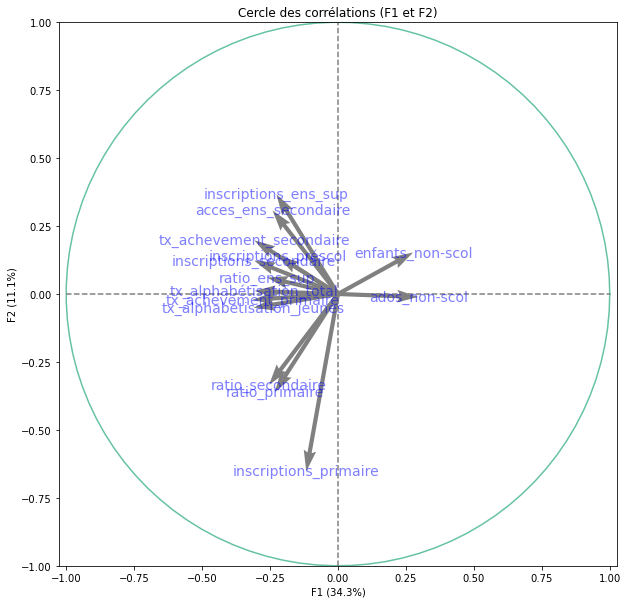

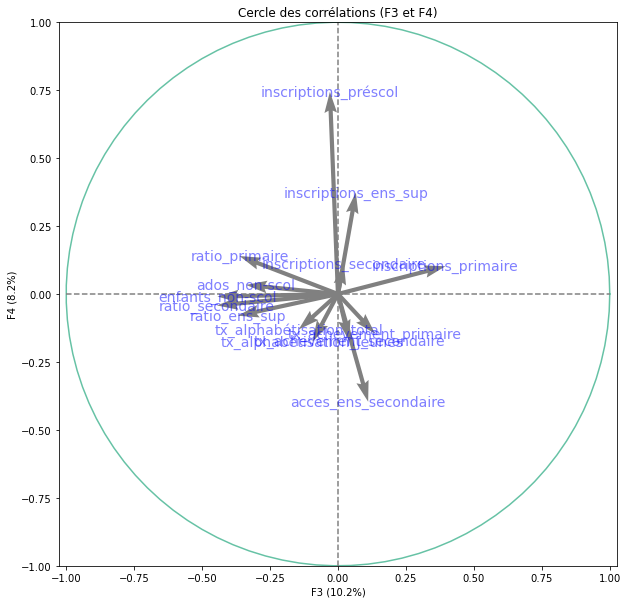

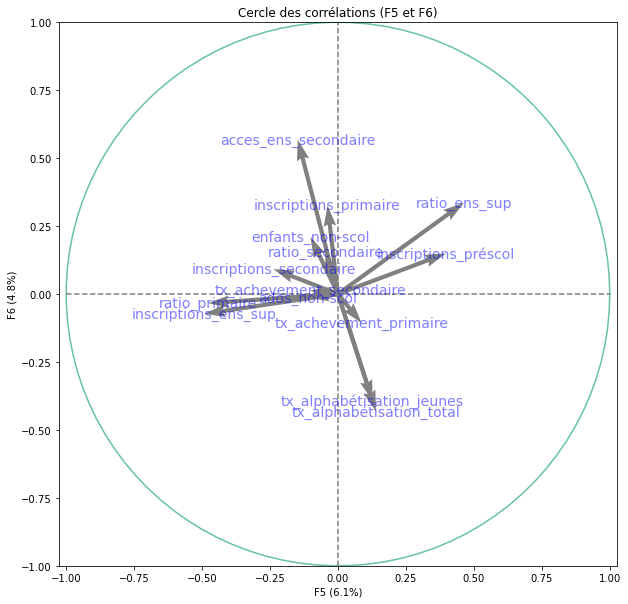

In [108]:
pcs3 = acp3.components_
features = data_acp3.columns
display_circles(pcs, p, acp3, [(0,1), (2,3), (4,5)], labels = np.array(features))

In [109]:
#cosinus carré des variables
cos2var = corvar**2
#print(pd.DataFrame({'id':data_acp3.columns,'COS2_1':cos2var[:,0],'COS2_2':cos2var[:,1], COS2_3':cos2var[:,2],'COS2_4':cos2var[:,3], COS2_5':cos2var[:,4],'COS2_6':cos2var[:,5]}))

In [110]:
#contributions
ctrvar = cos2var
for k in range(p):
  ctrvar[:,k] = ctrvar[:,k]/eigval[k]

#on n'affiche que pour les six premiers axes
print(pd.DataFrame({'id':data_acp3.columns,'CTR_1':ctrvar[:,0],'CTR_2':ctrvar[:,1], 'CTR_3':ctrvar[:,2],'CTR_4':ctrvar[:,3], 'CTR_5':ctrvar[:,4],'CTR_6':ctrvar[:,5]}))

                            id     CTR_1     CTR_2     CTR_3     CTR_4  \
0         acces_ens_secondaire  0.057676  0.011498  0.000042  0.006440   
1                ados_non-scol  0.082462  0.001657  0.000845  0.000179   
2             enfants_non-scol  0.070292  0.013864  0.002331  0.005153   
3         inscriptions_ens_sup  0.052070  0.004676  0.015879  0.027854   
4        inscriptions_primaire  0.010485  0.068967  0.013599  0.027486   
5         inscriptions_préscol  0.045460  0.014845  0.008965  0.063535   
6      inscriptions_secondaire  0.093373  0.000125  0.001322  0.004268   
7                ratio_ens_sup  0.063827  0.002837  0.015083  0.005491   
8               ratio_primaire  0.050017  0.009319  0.000089  0.025846   
9             ratio_secondaire  0.059246  0.005816  0.027660  0.031847   
10      tx_achevement_primaire  0.092424  0.003348  0.000070  0.002709   
11    tx_achevement_secondaire  0.092719  0.002115  0.001718  0.001362   
12   tx_alphabétisation_jeunes  0.0904

## Conclusion